In [1]:
import numpy as np
import pandas as pd
from time import sleep
import os 
import glob
import json
from pandas.plotting import scatter_matrix as sm
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from chime_frb_constants import K_DM, FREQ_BOTTOM_MHZ, FREQ_TOP_MHZ
import matplotlib.colors as colors

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 22
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=0.875, n=7):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def get_color_vals(time_res, cmap='viridis'):
    
    n_values = np.arange(9)  # n ranges from 0 to 8
    time_res_values = 2 ** n_values * 2.56 * 1e-6
    
    cmap_i = cmap
    print("Getting the normalizations ########")

    norm = mpl.colors.SymLogNorm(vmin=np.min(time_res_values), vmax=np.max(time_res_values), clip=False, base=2, linthresh=1e-6)

    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_i)

    print("\nGetting the colors ######")

    width_color = []

    for t in time_res:
        width_color.append(mapper.to_rgba(t))
        
    return width_color, mapper

In [3]:
#### Load catalog data ####

cat_file = '/arc/home/ksand/Basecat_morph/fitburst_runs/Run3_plots/catalog1.json'
f = open(cat_file)
data_cat = json.load(f)

catalog1_events = []

for i in range(len(data_cat)):
    catalog1_events.append(int(data_cat[i]['event_number']))
    
catalog1_events = np.array(catalog1_events)
df_cat = pd.DataFrame(data_cat)

####### Manipulating to add minimum width and bandwidth ###########

df_cat['pulse_width_ms'] = df_cat['pulse_width_ms'].apply(np.array)
w = df_cat['pulse_width_ms'].to_numpy()

for i in range(len(w)):
    for j in range(len(w[i])):
        try:
            w[i][j] = float(w[i][j].split('<')[-1])
        except:
            w[i][j] = float(w[i][j])

df_cat['pulse_width_ms_error'] = df_cat['pulse_width_ms_error'].apply(np.array)
w_err = df_cat['pulse_width_ms_error'].to_numpy()

df_cat['bandwidth_high'] = df_cat['bandwidth_high'].apply(np.array)
bw_high = df_cat['bandwidth_high'].to_numpy()

df_cat['bandwidth_low'] = df_cat['bandwidth_low'].apply(np.array)
bw_low = df_cat['bandwidth_low'].to_numpy()

width_min_int = []
width_min_int_err = []
bandwidth = []

bw_highest = []
bw_lowest = []

for i in range(len(w)):
    j = np.argmin(w[i])
    k = np.argmax(bw_high[i])
    l = np.argmin(bw_low[i])
    bandwidth.append(bw_high[i][k] - bw_low[i][l])
    
    bw_highest.append(bw_high[i][k])
    bw_lowest.append(bw_low[i][l])
    
    width_min_int.append(w[i][j])
    width_min_int_err.append(w_err[i][j])
    
df_cat['pulse_width_min'] = width_min_int
df_cat['pulse_width_min_err'] = width_min_int_err
df_cat['bandwidth'] = bandwidth

df_cat['hi'] = bw_highest
df_cat['lo'] = bw_lowest


###### Manipulating to get scattering measurements #####

sc_int = df_cat['scattering_time_ms'].to_numpy()
sc_int_err = df_cat['scattering_time_ms_error'].to_numpy()
sc_int_final = []
sc_limit = []
                                            
for i in range(len(sc_int)):
    if sc_int_err[i] == 0:
        x = sc_int[i].split('<')[-1]
        sc_int_final.append(float(x))
        sc_limit.append('two')
    else:
        sc_int_final.append(float(sc_int[i]))
        sc_limit.append('three')
                                             
df_cat['scattering_time_ms'] = sc_int_final
df_cat['scattering_limit'] = sc_limit

# print(df_cat[['box_car_width', 'event_number']])

In [4]:
data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json') #### Loading basecat information ####
data_basecat['Ratio(w/s)'] = round(data_basecat['Min_width(s)']/data_basecat['Scattering(s)'],2)
data_basecat['DM_eg'] = data_basecat['DM'] - data_basecat['MW_DM']
data_basecat['RM_eg'] = data_basecat['RM'] - data_basecat['MW_RM']
data_basecat['Sc_eg'] = data_basecat['Scattering(s)'] - data_basecat['MW_scat']
data_basecat['Width_ratio'] = data_basecat['Max_width(s)']/data_basecat['Min_width(s)']

print("Total number of events", len(data_basecat))
# display(data_basecat)

data_only_scat = data_basecat[(data_basecat['Fit_type'] == 'Scint') | (data_basecat['Fit_type'] == 'Scat')]
print("Total number of events with scattering and scintillation fits", len(data_only_scat))

data_only_profile = data_basecat[(data_basecat['Fit_type'] == 'Profile')]
print("Total number of events with profile fits", len(data_only_profile))
# display(data_only_profile)

# data_less_scat = data_only_scat[(data_only_scat['Scattering(s)'] < 0.0001)]
# print(len(data_less_scat))
#display(data_less_scat)


# data_no_scint = data_basecat[(data_basecat['Fit_type'] != 'Scint')]



data_final_basecat = data_basecat[(data_basecat['Min_width(s)'] > 5e-6)]
print("Final list", len(data_final_basecat))
display(data_final_basecat)


# data_micro_bursts = data_final_basecat[(data_final_basecat['Min_width(s)'] <= (100e-6/2.35))]
# print("Bursts with component less than 100 microseconds FWHM", len(data_micro_bursts))

# data_no_sim = data_final_basecat[(data_final_basecat['Sim_fit_snr_mean'] == 0)]
# print("Data with no simulation results", len(data_no_sim))
# # display(data_no_sim)

# # data_final_basecat = data_final_basecat[(data_final_basecat['Min_width_err(s)'] < data_final_basecat['Min_width(s)'])]
# # display(data_final_basecat)
# # print("Displaying events with good width measurements")
# # display(data_final_basecat)
# #data_final_basecat = data_final_basecat.dropna()

# print("Events in the final dataframe", len(data_final_basecat))

# #### Finding events that have to be re-done #####

# data_failed = data_basecat[(data_basecat['Fit_type'] == 'Failed')]

# print("Events with failed fits", len(data_failed))
# # display(data_failed)

# data_wrong_width = data_basecat[(data_basecat['Min_width(s)'] < 5e-6)]

# print("Data with very low widths", len(data_wrong_width))
# # display(data_wrong_width)

# data_wrong_width_err = data_basecat[(data_basecat['Min_width_err(s)'] > data_basecat['Min_width(s)'])]
# print("Data with incorrect width errors", len(data_wrong_width_err))

# # display(data_wrong_width_err)

# data_width_less_time_res = data_basecat[(data_basecat['Min_width(s)'] < 0.23 * data_basecat['Time_res(s)'])]
# #data_width_less_time_res = data_width_less_time_res[(data_width_less_time_res['Min_width(s)'] > 5e-6)]

# print("Data with width less than measured time resolution", len(data_width_less_time_res))

# display(data_width_less_time_res)

# data_nans = data_basecat[data_basecat.isna().any(axis=1)]
# data_nans = data_nans[(data_nans['Min_width(s)'] > 5e-6)]

# print("Data with Nans", len(data_nans))

# display(data_nans)

# data_high_res = data_basecat[(data_basecat['Time_res(s)'] == 2.56e-6)]
# print("Events with high time res data", len(data_high_res))

# ####### Looking at different events ##########

# data_final_basecat_no_profile = data_final_basecat[(data_final_basecat['Fit_type'] != 'Profile')]
# data_final_basecat_only_profile = data_final_basecat[(data_final_basecat['Fit_type'] == 'Profile')]


data_only_scat_final = data_final_basecat[(data_final_basecat['Fit_type'] == 'Scint') | (data_final_basecat['Fit_type'] == 'Scat')]

# print("Events in the final dataframe with scattering and scintillation fits", len(data_only_scat_final))
# #display(data_only_scat_final)

# data_high_scat = data_only_scat_final[(data_only_scat_final['Scattering(s)'] > 5e-3)]
# print("Events with high scattering", len(data_high_scat))
# display(data_high_scat)

data_no_scat_final = data_final_basecat[(data_final_basecat['Fit_type'] == 'Noscat')]


# data_low_width = data_final_basecat[(data_final_basecat['Min_width(s)'] < 50e-6)]
# print("Length of less width", len(data_low_width))
# # display(data_low_width)

# data_single = data_final_basecat[(data_final_basecat['Num_comps'] == 1)]
# data_single_narrow = data_single[(data_single['Min_width(s)'] < 0.0009)]
# display(data_single_narrow)

# data_multi = data_final_basecat[(data_final_basecat['Num_comps'] > 1)]
# print("Events with multiple components", len(data_multi))
# # display(data_only_scat_final)

Total number of events 137
Total number of events with scattering and scintillation fits 87
Total number of events with profile fits 22
Final list 137


,Event,Fit_type,TNS_name,Time_res(s),DM,DM_err,Flux(Jy),Flux_err(Jy),Fluence(Jy_ms),Fluence_err(Jy_ms),RM,RM_err,Pol_frac,Pol_frac_err,Pol_frac_upper,Sig_RM_limit,Widths(s),Widths_err(s),Widths_err_sim(s),Min_width(s),Min_width_err(s),Min_width_err_sim(s),Max_width(s),Max_width_err(s),Max_width_err_sim(s),Scattering(s),Scattering_err(s),Scattering_err_sim(s),Num_comps,Boxcar_width(s),Fitburst_chi_sqr,Fit_snr,Bandwidth_low,Bandwidth_high,Bandwidth,Top_avail_freq,Sim_scat_err_percent,Sim_width_err_percent,Sim_fit_snr_mean,MW_DM,MW_RM,MW_RM_err,MW_scat,Repeater,Ratio(w/s),DM_eg,RM_eg,Sc_eg,Width_ratio
0,22154974,Scint,FRB20181209A,0.000003,328.592265,0.009821,16.932807,1.702109,11.065309,1.138121,-110.3,0.051,0.90,0.011,-1.000,0.918087,[4.768360137867595e-05],[1.5256020457061478e-06],[9.187944668779769e-07],0.000048,1.525602e-06,9.187945e-07,0.000048,1.525602e-06,9.187945e-07,0.000114,1.104592e-06,0.000004,1,0.000576,0.934452,146.444647,400.195312,800.195312,400.000000,800.195312,3.653516,1.926856,139.646670,95.493259,-21,8,3.583425e-06,False,0.42,233.099006,-89.3,0.000110,1.000000
1,22310619,Scint,FRB20181213A,0.000020,678.690379,0.011710,6.337638,0.653551,8.176461,0.885456,10.2,0.092,1.09,0.033,-1.000,0.000000,"[7.810057339618419e-05, 4.8295026501822585e-05...","[4.097062896981601e-06, 5.874072296003162e-06,...","[1.557235476661156e-05, 9.629472018524685e-06,...",0.000048,5.874072e-06,9.629472e-06,0.000078,4.097063e-06,1.557235e-05,0.000167,2.438361e-06,0.000046,3,0.002683,0.963051,91.416743,400.195312,800.195312,400.000000,800.195312,27.266337,19.938848,90.833009,78.540010,-12,6,1.845107e-06,False,0.29,600.150369,22.2,0.000166,1.617156
2,22457855,Scat,FRB20181214C,0.000082,632.827111,0.006636,4.503233,0.481316,15.218117,1.587706,23.6,0.206,0.60,0.028,-1.000,2.021535,"[0.00038195614126100005, 6.706078347096188e-05]","[1.557235476661156e-05, 9.629472018524685e-06,...","[3.249944663114827e-05, 5.705991128356625e-06]",0.000067,5.705991e-06,5.705991e-06,0.000382,3.249945e-05,3.249945e-05,0.001599,6.619611e-05,0.000199,2,0.006881,0.985750,57.538622,400.195312,800.195312,400.000000,800.195312,12.448445,8.508685,69.091103,63.337543,6,2,7.801473e-07,False,0.04,569.489568,17.6,0.001599,5.695671
3,22574084,Profile,FRB20181215B,0.000003,494.044029,0.005933,14.328002,1.436619,12.543438,1.262924,8.6,0.022,1.02,0.009,-1.000,0.000000,"[1.3837813459083203e-05, 4.9612728404805506e-0...","[2.058903718113965e-07, 8.030663904185624e-07,...",[0.0],0.000014,2.058904e-07,0.000000e+00,0.000196,6.143760e-06,0.000000e+00,0.000006,1.782339e-07,0.000000,4,0.000635,0.000000,0.000000,400.195312,800.195312,400.000000,800.195312,0.000000,0.000000,0.000000,70.436366,14,4,1.357931e-06,False,2.33,423.607663,-5.4,0.000005,14.128596
4,23070533,Scint,FRB20181219C,0.000328,647.762798,0.041208,3.867239,0.435312,17.462872,1.838531,9999.0,0.000,-1.00,0.000,0.210,-1.000000,[0.000614494089507],[2.6744827917733282e-05],[3.0385399955067662e-05],0.000614,2.674483e-05,3.038540e-05,0.000614,2.674483e-05,3.038540e-05,0.001052,2.286320e-05,0.000112,1,0.010158,0.908123,61.551006,400.195312,800.195312,400.000000,800.195312,10.643646,4.944783,64.108865,66.391929,9999,0,9.312322e-07,False,0.58,581.370868,0.0,0.001051,1.000000
5,23232723,Scint,FRB20181220A,0.000020,209.516784,0.008116,0.000000,0.000000,0.000000,0.000000,97.5,0.379,0.43,0.024,-1.000,2.598415,[7.359974807495678e-05],[4.452494125703943e-06],[1.819452012719509e-06],0.000074,4.452494e-06,1.819452e-06,0.000074,4.452494e-06,1.819452e-06,0.000213,3.824171e-06,0.000010,1,0.001331,0.940617,77.567730,400.195312,800.195312,400.000000,800.195312,4.495174,2.472090,79.132844,148.552562,-23,11,1.723378e-05,False,0.35,60.964222,120.5,0.000196,1.000000
6,23438043,Scint,FRB20181221A,0.000164,316.292530,0.048223,3.287623,0.342141,15.158627,1.552647,39.0,0.366,0.42,0.022,-1.000,2.634389,[0.00047146557031800003],[2.3946117543336352e-05],[2.3895317886298523e-05],0.000471,2.394612e-05,2.389532e-05,0.000471,2.394612e-05,2.389532e-05,0.00138

In [5]:
##### Getting data from the table ###

data_width_noscat = data_basecat[(data_basecat['Fit_type'] == 'Noscat')]
data_width_noscat_multi = data_width_noscat[(data_width_noscat['Num_comps'] > 1)]
display(data_width_noscat_multi)

,Event,Fit_type,TNS_name,Time_res(s),DM,DM_err,Flux(Jy),Flux_err(Jy),Fluence(Jy_ms),Fluence_err(Jy_ms),RM,RM_err,Pol_frac,Pol_frac_err,Pol_frac_upper,Sig_RM_limit,Widths(s),Widths_err(s),Widths_err_sim(s),Min_width(s),Min_width_err(s),Min_width_err_sim(s),Max_width(s),Max_width_err(s),Max_width_err_sim(s),Scattering(s),Scattering_err(s),Scattering_err_sim(s),Num_comps,Boxcar_width(s),Fitburst_chi_sqr,Fit_snr,Bandwidth_low,Bandwidth_high,Bandwidth,Top_avail_freq,Sim_scat_err_percent,Sim_width_err_percent,Sim_fit_snr_mean,MW_DM,MW_RM,MW_RM_err,MW_scat,Repeater,Ratio(w/s),DM_eg,RM_eg,Sc_eg,Width_ratio
23,25281508,Noscat,FRB20190106B,0.000010,316.531040,0.002125,27.368117,2.749904,25.006310,2.528786,-73.2,0.031,0.91,0.009,-1.00,0.868611,"[1.4587967783511161e-05, 6.810218873712176e-05...","[2.8886754708376464e-07, 1.025076250978802e-06...","[4.0479278193297264e-07, 1.8897268518637159e-0...",0.000015,2.888675e-07,4.047928e-07,0.000228,0.000018,0.000006,0.000015,0.0,0.0,5,0.001382,0.902105,164.138185,400.195312,776.734902,376.539589,776.734902,0.0,2.774840,164.880048,161.599079,-133,36,2.230431e-05,False,1.0,154.931961,59.8,-0.000008,15.638421
27,26690059,Noscat,FRB20190115B,0.000164,748.187290,0.026326,3.529723,0.390875,7.815784,0.856230,9999.0,0.000,-1.00,0.000,0.10,-1.000000,"[0.000324841983142, 0.00032800176968000004, 0....","[6.724606063533458e-05, 2.9352923177688174e-05...","[1.3450977669773301e-05, 1.3581817340658233e-0...",0.000325,6.724606e-05,1.345098e-05,0.000552,0.000063,0.000023,0.000325,0.0,0.0,3,0.005898,0.966222,35.763610,400.195312,800.195312,400.000000,800.195312,0.0,4.140776,42.483120,93.594668,9999,0,3.516122e-06,False,1.0,654.592622,0.0,0.000321,1.699923
44,30282040,Noscat,FRB20190212B,0.000010,600.180512,0.002868,4.443331,0.458394,7.660268,0.798021,175.8,0.188,0.73,0.021,-1.00,1.586722,"[8.68293922689184e-05, 8.89745057994152e-05, 0...","[4.114019718611842e-06, 5.685392265263113e-06,...","[1.819338764898255e-06, 1.864285390679691e-06,...",0.000087,4.114020e-06,1.819339e-06,0.000685,0.000028,0.000014,0.000087,0.0,0.0,3,0.001679,0.974974,71.216246,400.195312,800.195312,400.000000,800.195312,0.0,2.095303,74.335368,71.160451,-10,3,1.168437e-06,False,1.0,529.020061,185.8,0.000086,7.889314
53,32158184,Noscat,FRB20190301A,0.000655,459.782965,0.043097,3.344246,0.405881,13.504203,1.510777,9999.0,0.000,-1.00,0.000,-1.00,-1.000000,"[0.0005001079216750001, 0.001032836260409, 0.0...","[3.322069269608038e-05, 3.822796689200604e-05,...","[5.834942967099269e-05, 0.00012050480331600001...",0.000500,3.322069e-05,5.834943e-05,0.003336,0.000331,0.000389,0.000500,0.0,0.0,3,0.013763,0.953182,66.592141,533.528646,666.861979,133.333333,800.195312,0.0,11.667368,70.239587,117.343141,9999,0,7.913604e-06,True,1.0,342.439824,0.0,0.000492,6.670300
65,36234050,Noscat,FRB20190411B,0.000164,1229.423085,0.011809,1.543778,0.206953,4.992985,0.569380,9999.0,0.000,-1.00,0.000,0.23,-1.000000,"[0.000316497180416, 0.00053479288818, 0.000423...","[4.8032641160232495e-05, 0.000153868461068, 7....","[2.4671344406384754e-05, 4.168776326236045e-05...",0.000316,4.803264e-05,2.467134e-05,0.000535,0.000154,0.000042,0.000316,0.0,0.0,3,0.004588,0.966947,26.010192,400.195312,628.152302,227.956989,628.152302,0.0,7.795123,34.538450,65.274403,9999,0,8.042922e-07,False,1.0,1164.148682,0.0,0.000316,1.689724
85,39218186,Noscat,FRB20190519G,0.000655,429.966821,0.487796,1.516716,0.178768,30.779759,3.127868,9999.0,0.000,-1.00,0.000,-1.00,-1.000000,"[0.001889416536366, 0.007830420676163]","[0.00027668271047000004, 0.00037230183137500005]","[7.389824225120987e-05, 0.00030626085509300003]",0.001889,2.766827e-04,7.389824e-05,0.007830,0.000372,0.000306,0.001889,0.0,0.0,2,0.028180,0.985284,44.913626,400.195312,800.195312,400.000000,800.195312,0.0,3.911167,39.992904,103.375423,9999,0,5.270056e-06,False,1.0,326.591398,0.0,0.001884,4.144359
90,40750656,Noscat,FRB20190605B,0.000655,349.093346,0.057345,3.157716,0.322563,49.397766,4.960442,9999.0,0.000,-1.00,0.000,-1.00,-1.000000,"[0

In [6]:
######## Intensity data of all basecat events in numpy ############

# mypath = '/arc/projects/chime_frb/baseband_catalog/beamformed_files'
# singlebeam_files = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
# event_ids = []
# for i in range(len(singlebeam_files)):
#     f = (singlebeam_files[i].split('.')[0]).split('_')[-2]
#     event_ids.append(f)
#     #print(f, singlebeam_files[i])

# event_ids.remove('41365524')  ### This is the event id where we can't see the burst or the burst is too weak ######
# event_ids.remove('42842438') ### This is the event id where we can't see the burst or the burst is too weak ######
# event_ids.remove('42637411') ### This is the event id where we can't see the burst or the burst is too weak ######

# singlebeam_files.remove('FRB20190612A_41365524_beamformed.h5')

# singlebeam_files.remove('FRB20190628C_42842438_beamformed.h5')

# singlebeam_files.remove('FRB20190627D_42637411_beamformed.h5')

# event_ids = np.array(event_ids).astype(int)
# singlebeam_files = np.array(singlebeam_files)

# events = event_ids.astype(str) ##### since it is in the form of string ######

#### If you only want to keep event ids in the final version of basecat ######

events = data_final_basecat['Event'].to_numpy().astype(str)

print(len(data_final_basecat))
print(len(events))

df_new_cat = df_cat[df_cat['event_number'].isin(events)] 

df_new_cat = df_new_cat.sort_values(by = 'event_number')


events_int = df_new_cat['event_number'].to_numpy().astype(int)
dms_int = df_new_cat['fitburst_dm'].to_numpy().astype(float)
dms_int_err = df_new_cat['fitburst_dm_error'].to_numpy().astype(float)
scats_int = df_new_cat['scattering_time_ms'].to_numpy().astype(float)
scats_int_err = df_new_cat['scattering_time_ms_error'].to_numpy().astype(float)
widths_min_int = df_new_cat['pulse_width_min'].to_numpy().astype(float)
print(len(widths_min_int))
widths_min_int_err = df_new_cat['pulse_width_min_err'].to_numpy().astype(float)
bws_int = df_new_cat['bandwidth'].to_numpy().astype(float)
ncomps_int = df_new_cat['num_sub_bursts'].to_numpy().astype(int)
boxcar_int = df_new_cat['box_car_width'].to_numpy().astype(float)

137
137
137


In [7]:
print(df_new_cat['hi'].tolist())

[544.71435546875, 800.1953125, 800.1953125, 800.1953125, 735.53466796875, 596.35009765625, 583.33740234375, 597.64404296875, 672.32666015625, 800.1953125, 800.1953125, 510.80322265625, 632.67822265625, 800.1953125, 558.31298828125, 471.81396484375, 800.1953125, 800.1953125, 799.98779296875, 667.02880859375, 595.47119140625, 800.1953125, 782.99560546875, 543.46923828125, 472.74169921875, 477.67333984375, 609.09423828125, 800.1953125, 800.1953125, 583.97216796875, 580.94482421875, 800.1953125, 800.1953125, 800.1953125, 617.44384765625, 553.55224609375, 576.79443359375, 632.06787109375, 800.1953125, 563.36669921875, 800.1953125, 644.59228515625, 583.21533203125, 696.05712890625, 702.01416015625, 800.1953125, 800.1953125, 671.69189453125, 800.1953125, 800.1953125, 800.1953125, 800.1953125, 800.1953125, 696.03271484375, 786.68212890625, 504.69970703125, 646.49658203125, 800.1953125, 800.1953125, 800.1953125, 800.1953125, 800.1953125, 800.1953125, 800.1953125, 542.49267578125, 800.1953125, 8

In [9]:
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 100)
# # for i in range(len(data_basecat['Widths(s)'])):
# #     print(data_basecat['Widths(s)'][i], data_basecat['Event'][i], data_basecat['Fit_type'][i])

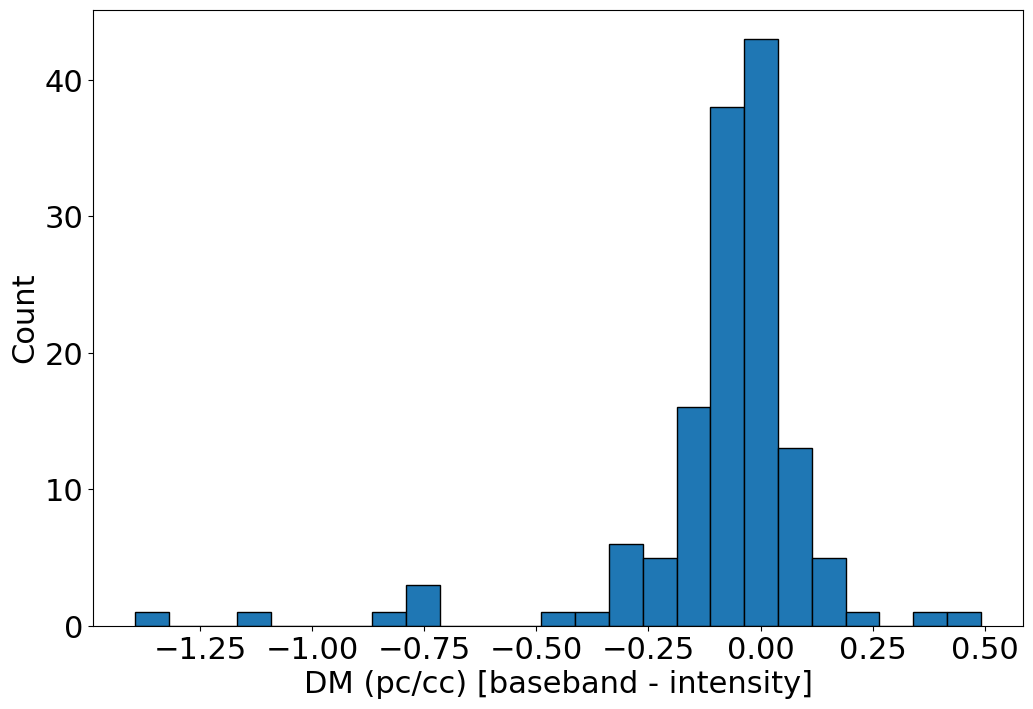

In [8]:
#### DM #####

dms_base = data_final_basecat['DM'].to_numpy().astype(float)
events = data_final_basecat['Event'].to_numpy().astype(int)


plt.hist(dms_base - dms_int, bins=25, edgecolor = 'k')
plt.xlabel("DM (pc/cc) [baseband - intensity]")
plt.ylabel("Count")
plt.show()


Number of events with more components in baseband is 52 thats total percentage 37.956204379562045 %


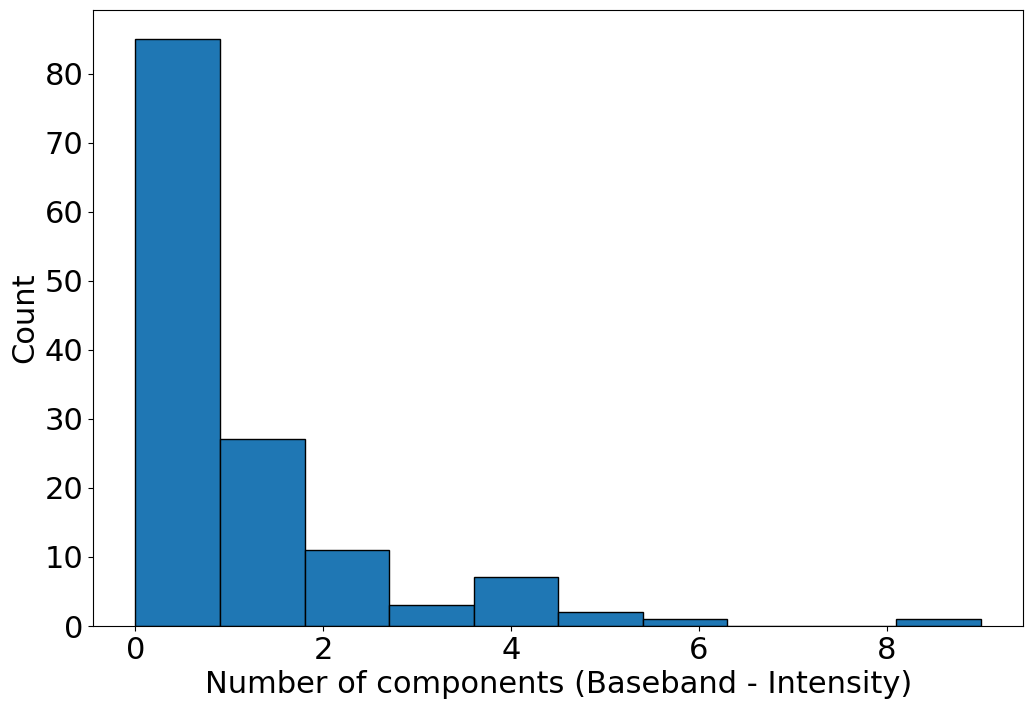

In [9]:
#### Num of comps ###

ncomps_base = data_final_basecat['Num_comps'].to_numpy().astype(int)

#### Removing failed events ###

# idx = np.where(ncomps_base == 0)[0]


# ncomps_base_del = np.delete(ncomps_base, idx)
# ncomps_int_del = np.delete(ncomps_int, idx)

comp_diff = ncomps_base - ncomps_int

n = len(np.where(comp_diff >= 1)[0])
print("Number of events with more components in baseband is", n, "thats total percentage", n*100/len(comp_diff), "%")

plt.hist(comp_diff, linewidth=1, edgecolor='k', bins=10)
plt.xlabel("Number of components (Baseband - Intensity)")
plt.ylabel("Count")
plt.show()

In [10]:
##### Scattering #####

bins = 25

scats = data_only_scat_final['Scattering(s)'].to_numpy()
sc_errs = data_only_scat_final['Scattering_err_sim(s)'].to_numpy()
time_res = data_only_scat_final['Time_res(s)'].to_numpy()
# time_res = time_res 

# print(time_res)

### Taking only scattered events from intensity catalog ####

events_scat = data_only_scat_final['Event'].to_numpy().astype(str)

df_scat_cat = df_cat[df_cat['event_number'].isin(events_scat)] 

df_scat_cat = df_scat_cat.sort_values(by = 'event_number')

##### Separating them as measurements and upper limits ######

only_scats_int = df_scat_cat['scattering_time_ms'].to_numpy().astype(float)
only_scats_int_err = df_scat_cat['scattering_time_ms_error'].to_numpy().astype(float)
only_scats_type = df_scat_cat['scattering_limit'].to_numpy().astype(str)
only_scats_events = df_scat_cat['event_number'].to_numpy().astype(int)

scats_del = []
scats_int_del = []
sc_errs_del = []
scats_int_err_del = []
time_res_del = []
events_del = []

scats_upper_lims = [] 
scats_int_upper_lims = []
sc_errs_upper_lims = [] 
scats_int_err_upper_lims = []
time_res_upper_lims = []
events_upper_lims = []

for i in range(len(scats)):
    if only_scats_type[i] == 'three':
        # print(i, only_scats_type[i], events_scat[i], only_scats_events[i])
        scats_del.append(scats[i])
        sc_errs_del.append(sc_errs[i])
        scats_int_del.append(only_scats_int[i])
        scats_int_err_del.append(only_scats_int_err[i])
        time_res_del.append(time_res[i])
        events_del.append(events_scat[i])
        
        
        ###### Add time resolution here as well!!!! ######
    if only_scats_type[i] == 'two':
        #print(only_scats_int[i], only_scats_int_err[i])
        # print(i, only_scats_type[i], events_scat[i], only_scats_events[i])
        scats_upper_lims.append(scats[i])
        sc_errs_upper_lims.append(sc_errs[i])
        scats_int_upper_lims.append(only_scats_int[i])
        scats_int_err_upper_lims.append(only_scats_int_err[i])
        time_res_upper_lims.append(time_res[i])
        events_upper_lims.append(events_scat[i])
        
# print(len(scats_del), len(scats_upper_lims))
# for i in range(len(scats_del)):
#     if scats_int_del[i] < 0.0003 :
#         # print(scats_del[i], scats_int_del[i], events_del[i])

dms_base_scat = data_only_scat_final['DM'].to_numpy().astype(float)

print(len(scats), len(sc_errs))

######## Taking no scattering events ##########

scats_noscat = data_no_scat_final['Min_width(s)'].to_numpy().astype(float) 
time_res_noscat = data_no_scat_final['Time_res(s)'].to_numpy().astype(float)
time_res_noscat = time_res_noscat
events_noscat = data_no_scat_final['Event'].to_numpy().astype(str)

df_noscat_cat = df_cat[df_cat['event_number'].isin(events_noscat)] 

df_noscat_cat = df_noscat_cat.sort_values(by = 'event_number')


####### Separating them ###########

no_scats_int = df_noscat_cat['scattering_time_ms'].to_numpy().astype(float)
no_scats_int_err = df_noscat_cat['scattering_time_ms_error'].to_numpy().astype(float)
no_scats_type = df_noscat_cat['scattering_limit'].to_numpy().astype(str)
no_scats_events = df_noscat_cat['event_number'].to_numpy().astype(int)

print(len(events_noscat), len(no_scats_events))

noscats_del = []
noscats_int_del = []
nosc_errs_del = []
noscats_int_err_del = []
notime_res_del = []
noevents_del = []

noscats_upper_lims = [] 
noscats_int_upper_lims = []
nosc_errs_upper_lims = [] 
noscats_int_err_upper_lims = []
notime_res_upper_lims = []
noevents_upper_lims = []

for i in range(len(scats_noscat)):
    if no_scats_type[i] == 'three':
        # print(i, only_scats_type[i], events_scat[i], only_scats_events[i])
        noscats_del.append(scats_noscat[i])
        nosc_errs_del.append(float(0))
        noscats_int_del.append(no_scats_int[i])
        noscats_int_err_del.append(no_scats_int_err[i])
        notime_res_del.append(time_res_noscat[i])
        noevents_del.append(events_noscat[i])
        
        
        ###### Add time resolution here as well!!!! ######
    if no_scats_type[i] == 'two':
        #print(only_scats_int[i], only_scats_int_err[i])
        # print(i, no_scats_type[i], scats_noscat[i], no_scats_int[i], no_scats_events[i])
        noscats_upper_lims.append(scats_noscat[i])
        nosc_errs_upper_lims.append(float(0))
        noscats_int_upper_lims.append(no_scats_int[i])
        noscats_int_err_upper_lims.append(no_scats_int_err[i])
        notime_res_upper_lims.append(time_res_noscat[i])
        noevents_upper_lims.append(events_noscat[i])

87 87
28 28


Getting the normalizations ########

Getting the colors ######
Y tick labels are [  2.56   5.12  10.24  20.48  40.96  81.92 163.84 327.68 655.36]


/tmp/ipykernel_5347/3032766296.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(ytick_lab)


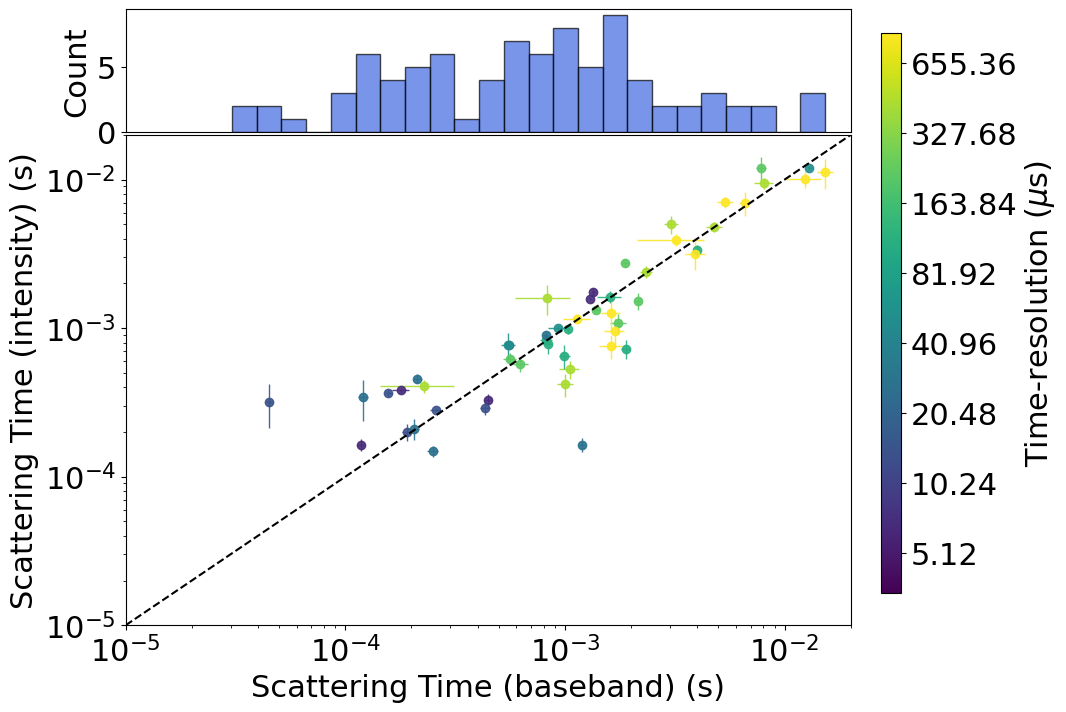

In [11]:
#### Plotting the scatter and histogram #######

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[1, 4], hspace=0.01)

# Plot histogram
ax_hist = plt.subplot(gs[0, 0])
hist, bins_w = np.histogram(scats, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]), np.log10(bins_w[-1]), bins)
ax_hist.hist(scats, bins=logbins, alpha=0.7, edgecolor='k', color='royalblue')
ax_hist.set_xscale('log')
ax_hist.set_ylabel('Count')
ax_hist.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)

# Plot scatter
ax_scatter = plt.subplot(gs[1, 0], sharex=ax_hist)

width_color, mapper = get_color_vals(time_res_del)

# # Plotting the scatter with error bars and colors
for x, y, xe, ye, color, t in zip(scats_del, scats_int_del, sc_errs_del, scats_int_err_del, width_color, time_res_del):
    ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.9, marker='o')

# # Set log scale for both x and y axes
ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')

# # Set limits
ax_scatter.set_xlim(0.00001, 0.02)
ax_scatter.set_ylim(0.00001, 0.02)

# Plot diagonal line
x = [0.00001, 0.02]
y = [0.00001, 0.02]
ax_scatter.plot(x, y, linestyle='--', c='k')

# # Set labels
ax_scatter.set_xlabel("Scattering Time (baseband) (s)")
ax_scatter.set_ylabel("Scattering Time (intensity) (s)")

# # Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)

# Set y-tick labels for the colorbar
ytick_lab = (np.logspace(0, 8, base=2, num=9) * 2.56).astype(float)
print("Y tick labels are", ytick_lab)
cbar_ax.set_yticklabels(ytick_lab)
# cbar_ax.set_yticks(norm(time_res_del))
cb.set_label(label=r'Time-resolution ($\mu$s)', size=22)
cbar_ax.tick_params(labelsize=22)

plt.show()

Getting the normalizations ########

Getting the colors ######
Getting the normalizations ########

Getting the colors ######
Getting the normalizations ########

Getting the colors ######
Getting the normalizations ########

Getting the colors ######
Y tick labels are [  2   5  10  20  40  81 163 327 655]


/tmp/ipykernel_5347/3275564122.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(ytick_lab)


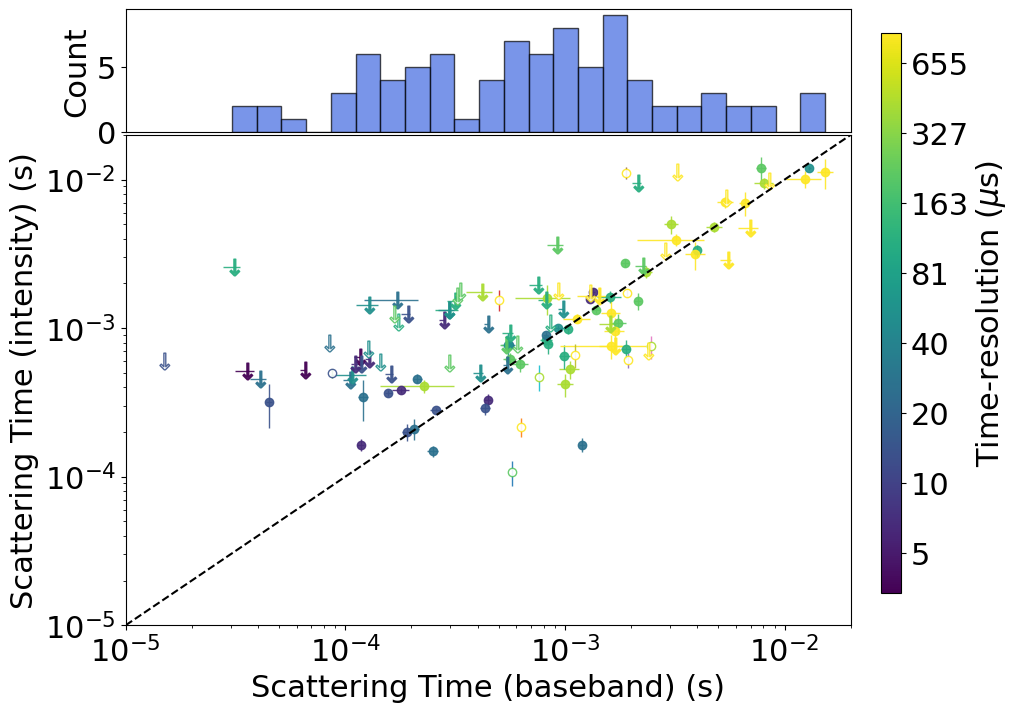

' Adjust only for ones we have measured scattering and add color bar that encodes time resolution information'

In [12]:

#### Plotting the scatter and histogram #######

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[1, 4], hspace=0.01)

ax_hist = plt.subplot(gs[0, 0], )
hist, bins_w = np.histogram(scats, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]), np.log10(bins_w[-1]), bins)
ax_hist.hist(scats, bins=logbins, alpha=0.7, edgecolor='k', color='royalblue')
ax_hist.set_xscale('log')
ax_hist.set_ylabel('Count')
ax_hist.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop = False)


# Plot intensity vs baseband on the right
ax_scatter = plt.subplot(gs[1, 0], sharex=ax_hist)

width_color, mapper = get_color_vals(time_res_del)

# Plotting the scatter
for x, y, xe, ye, color in zip(scats_del, scats_int_del, sc_errs_del, scats_int_err_del, width_color):
    ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.9, marker='o')
    

width_color, mapper = get_color_vals(time_res_upper_lims)

for x, y, xe, ye, color, t in zip(scats_upper_lims, scats_int_upper_lims, sc_errs_upper_lims, scats_int_err_upper_lims, width_color, time_res):
    ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.9, marker=r'$\downarrow$', markersize = 12)
    

width_color, mapper = get_color_vals(notime_res_del)

# Plotting the scatter
for x, y, xe, ye, color in zip(noscats_del, noscats_int_del, nosc_errs_del, noscats_int_err_del, width_color):
    ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.9, marker='o', mfc='w')
    

width_color, mapper = get_color_vals(notime_res_upper_lims)

for x, y, xe, ye, color in zip(noscats_upper_lims, noscats_int_upper_lims, nosc_errs_upper_lims, noscats_int_err_upper_lims, width_color):
    ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.9, marker=r'$\downarrow$', markersize = 12, mfc='w' )

# Set log scale for both x and y axes
ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')

# Set limits
ax_scatter.set_xlim(0.00001, 0.02)
ax_scatter.set_ylim(0.00001, 0.02)

# Plot diagonal line
x = [0.00001, 0.02]
y = [0.00001, 0.02]
ax_scatter.plot(x, y, linestyle='--', c='k')

# Set labels
ax_scatter.set_xlabel("Scattering Time (baseband) (s)")
ax_scatter.set_ylabel("Scattering Time (intensity) (s)")

# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)
ytick_lab = (np.logspace(0, 8, base=2, num=9) * 2.56).astype(int)
print("Y tick labels are", ytick_lab)
cbar_ax.set_yticklabels(ytick_lab)
cb.set_label(label=r'Time-resolution ($\mu$s)', size=22)
cbar_ax.tick_params(labelsize=22)

oname = 'Paper_plots/Scattering_baseband_vs_intensity.pdf'
# plt.savefig(oname, dpi=300, bbox_inches='tight')

plt.show()


##### Plot the ratio #######

# ratio_scats = scats_int/scats
# hist, bins_w = np.histogram(ratio_scats, bins=bins)
# logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
# plt.hist(ratio_scats, bins=logbins, alpha=0.7, edgecolor='k')
# plt.axvline(1, color = 'k', linestyle='--')
# plt.xscale('log')
# plt.xlabel('Scattering ratio (Intensity / Baseband)')
# plt.show()

#### Print dm difference for these as well ########

#### Most had dm underestimated in intensity hence the sweep is taken as scattering in the fit ####

##### For once which we have more DM is baseband I have to look, maybe the error will take care of the change ######

# for i in range(len(events_scat)):
#     if ratio_scats[i] < 0.7 :  #### More than 20% change #######
#         #print(events_scat[i], scats_int[i], scats[i])
#         print("DM difference for event", events_scat[i] ,"is", dms_int_scat[i] - dms_base_scat[i], "The ratio is", ratio_scats[i])


''' Adjust only for ones we have measured scattering and add color bar that encodes time resolution information'''

137
Getting the normalizations ########

Getting the colors ######


/tmp/ipykernel_5347/3987908552.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(ytick_lab)


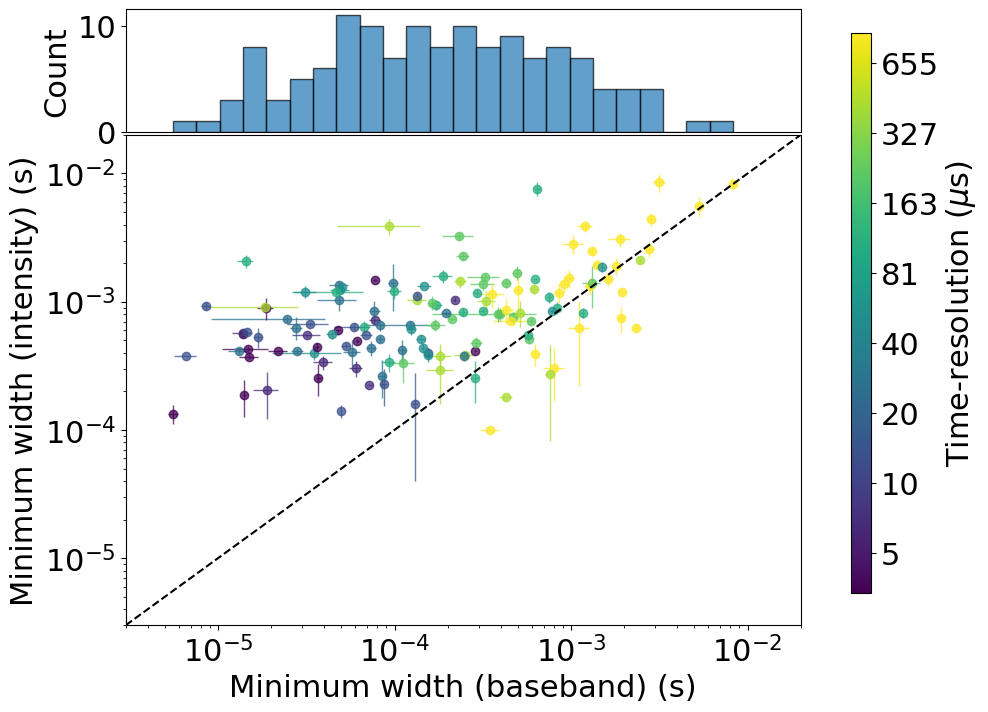

In [13]:
###### Minimum width #####
##### Make sure to remove the bursts with zero values #####
##### Plot the errorbars ####

''' Add color bar that encodes time resolution information'''
''' Make histogram distribution in log space'''

bins = 25

min_width_base = data_final_basecat['Min_width(s)'].to_numpy().astype(float)  
min_width_base_err = data_final_basecat['Min_width_err(s)'].to_numpy().astype(float)
time_res = data_final_basecat['Time_res(s)'].to_numpy().astype(float)

# print(time_res)

widths_min_int = df_new_cat['pulse_width_min'].to_numpy().astype(float)
widths_min_int_err = df_new_cat['pulse_width_min_err'].to_numpy().astype(float)

print(len(widths_min_int))


fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[1, 4], hspace=0.01)

ax_hist = plt.subplot(gs[0, 0])
hist, bins_w = np.histogram(min_width_base, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]), np.log10(bins_w[-1]), bins)
ax_hist.hist(min_width_base, bins=logbins, alpha=0.7, edgecolor='k')
ax_hist.set_xscale('log')
ax_hist.set_ylabel('Count')
ax_hist.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop = False)


# wm = np.where(min_width_base < 1e-5)[0]

# for w in wm:
#     print(events_del[w], min_width_base_del[w])
    
##### Baseband vs Intensity #######

ax_scatter = plt.subplot(gs[1, 0], sharex=ax_hist)

# norm = mpl.colors.Normalize(vmin=np.min(time_res), vmax=np.max(time_res), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_i)
# width_color = np.array([(mapper.to_rgba(v)) for v in time_res])

width_color, mapper = get_color_vals(time_res)

# print(width_color.shape)

for x, y, xe, ye, color in zip(min_width_base, widths_min_int, min_width_base_err, widths_min_int_err, width_color):
    ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')

#plt.errorbar(min_width_base, widths_min_int, xerr = min_width_base_err ,yerr = widths_min_int_err, linestyle = ' ', markersize=10, marker='*')

ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')
ax_scatter.set_xlim(0.000003,0.02)
ax_scatter.set_ylim(0.000003,0.02)

x = [0.000003, 0.02]
y = [0.000003, 0.02]
ax_scatter.plot(x,y,linestyle='--',c='k')

ax_scatter.set_xlabel("Minimum width (baseband) (s)")
ax_scatter.set_ylabel("Minimum width (intensity) (s)")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)

ytick_lab = (np.logspace(0,8,base=2,num=9)*2.56).astype(int)
cbar_ax.set_yticklabels(ytick_lab)
cb.set_label(label=r'Time-resolution ($\mu$s)', size=22)
cbar_ax.tick_params(labelsize=22)

oname = 'Paper_plots/Min_Width_baseband_vs_intensity.pdf'
# plt.savefig(oname, dpi=300, bbox_inches='tight')

plt.show()


###### Ratio #########

# ratio_widths = widths_min_int/min_width_base
# hist, bins_w = np.histogram(ratio_widths, bins=bins)
# logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
# plt.hist(ratio_widths, bins=logbins, alpha=0.7, edgecolor='k')
# plt.axvline(1, color = 'k', linestyle='--')
# plt.xscale('log')
# plt.xlabel('Min Width ratio (Intensity / Baseband)')
# plt.show()

##### Print DM for these as well #####

# for i in range(len(events)):
#     if ratio_widths[i] < 1 :
#         print(events[i], widths_min_int[i], min_width_base[i])


0.0 2866.8521552610505
137
-0.48371818
2.12632360e-09


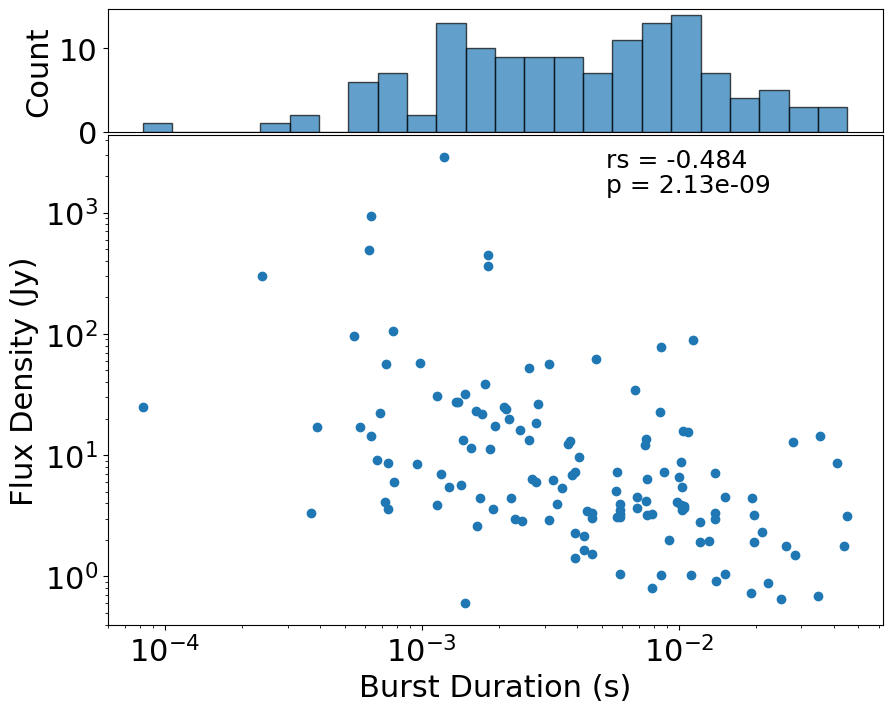

In [14]:
''' Add color bar that encodes time resolution information'''
''' Make histogram distribution in log space'''


def get_color_vals_flux(flux, cmap='viridis'):
    
    # n_values = np.arange(9)  # n ranges from 0 to 8
    # time_res_values = 2 ** n_values * 2.56 * 1e-6
    
    cmap_i = cmap
    print("Getting the normalizations ########")

    norm = mpl.colors.Normalize(vmin=np.min(flux), vmax=np.max(flux))

    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_i)

    print("\nGetting the colors ######")

    width_color = []

    for t in time_res:
        width_color.append(mapper.to_rgba(t))
        
    return width_color, mapper



bins = 25

boxcar_base = data_final_basecat['Boxcar_width(s)'].to_numpy().astype(float)  
boxcar_base_err = np.zeros(len(boxcar_base))
time_res = data_final_basecat['Time_res(s)'].to_numpy().astype(float)
flux = data_final_basecat['Flux(Jy)'].to_numpy().astype(float)


# for i in range(len(boxcar_base)):
#     print(boxcar_base[i]*1e3, boxcar_int[i]*1e3, events[i])
    
    
print(np.min(flux), np.max(flux))

# print(time_res)

boxcar_int = df_new_cat['box_car_width'].to_numpy().astype(float)
boxcar_int_err = np.zeros(len(boxcar_int))

print(len(widths_min_int))


fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[1, 4], hspace=0.01)

ax_hist = plt.subplot(gs[0, 0])
hist, bins_w = np.histogram(boxcar_base, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]), np.log10(bins_w[-1]), bins)
ax_hist.hist(boxcar_base, bins=logbins, alpha=0.7, edgecolor='k')
ax_hist.set_xscale('log')
ax_hist.set_ylabel('Count')
ax_hist.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop = False)


# wm = np.where(min_width_base < 1e-5)[0]

# for w in wm:
#     print(events_del[w], min_width_base_del[w])
    
##### Baseband vs Intensity #######

ax_scatter = plt.subplot(gs[1, 0], sharex=ax_hist)

# norm = mpl.colors.Normalize(vmin=np.min(time_res), vmax=np.max(time_res), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_i)
# width_color = np.array([(mapper.to_rgba(v)) for v in time_res])

# width_color, mapper = get_color_vals_flux(flux)

# # print(width_color.shape)

# for x, y, xe, ye, color in zip(boxcar_base, boxcar_int, boxcar_base_err, boxcar_int_err, width_color):
#     ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')

# #plt.errorbar(min_width_base, widths_min_int, xerr = min_width_base_err ,yerr = widths_min_int_err, linestyle = ' ', markersize=10, marker='*')

# ax_scatter.set_xscale('log')
# ax_scatter.set_yscale('log')
# ax_scatter.set_xlim(0.00005,0.05)
# ax_scatter.set_ylim(0.00005,0.05)

# x = [0.00005, 0.05]
# y = [0.00005, 0.05]
# ax_scatter.plot(x,y,linestyle='--',c='k')

# ax_scatter.set_xlabel("Boxcar width (baseband) (s)")
# ax_scatter.set_ylabel("Boxcar width (intensity) (s)")

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cb = fig.colorbar(mapper, cax=cbar_ax)

# # ytick_lab = np.logspace(min(flux),max(flux))
# # cbar_ax.set_yticklabels(ytick_lab)
# cb.set_label(label=r'Flux (Jy)', size=22)
# cbar_ax.tick_params(labelsize=22)

# oname = 'Paper_plots/Min_Width_baseband_vs_intensity.pdf'
# # plt.savefig(oname, dpi=300, bbox_inches='tight')

# plt.show()

ax_scatter.scatter(boxcar_base, flux)
ax_scatter.set_yscale('log')
ax_scatter.set_xscale('log')
ax_scatter.set_xlabel("Burst Duration (s)")
ax_scatter.set_ylabel("Flux Density (Jy)")

val, p = scipy.stats.spearmanr(boxcar_base, flux)
print(round(val,8))
print("{:.8e}".format(p))

ax_scatter.text(np.max(boxcar_base)-0.04, np.max(flux)-500, 'rs = {}'.format(round(val,3)), fontsize=18)
ax_scatter.text(np.max(boxcar_base)-0.04, np.max(flux)-1400, "p = {:.2e}".format(p), fontsize=18)

oname = 'Paper_plots/Boxcar_vs_Flux.jpg'
oname1 = 'Paper_plots/Boxcar_vs_Flux.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')


plt.show()

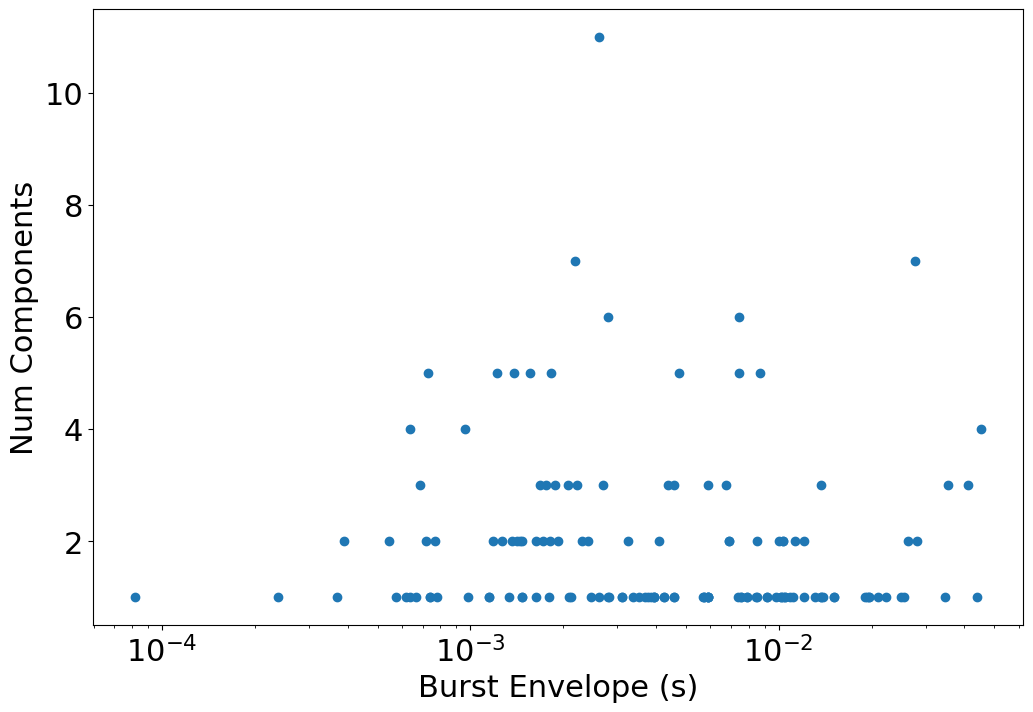

In [84]:
plt.scatter(boxcar_base, ncomps_base)
plt.xscale('log')
plt.xlabel("Burst Envelope (s)")
plt.ylabel("Num Components")
plt.show()

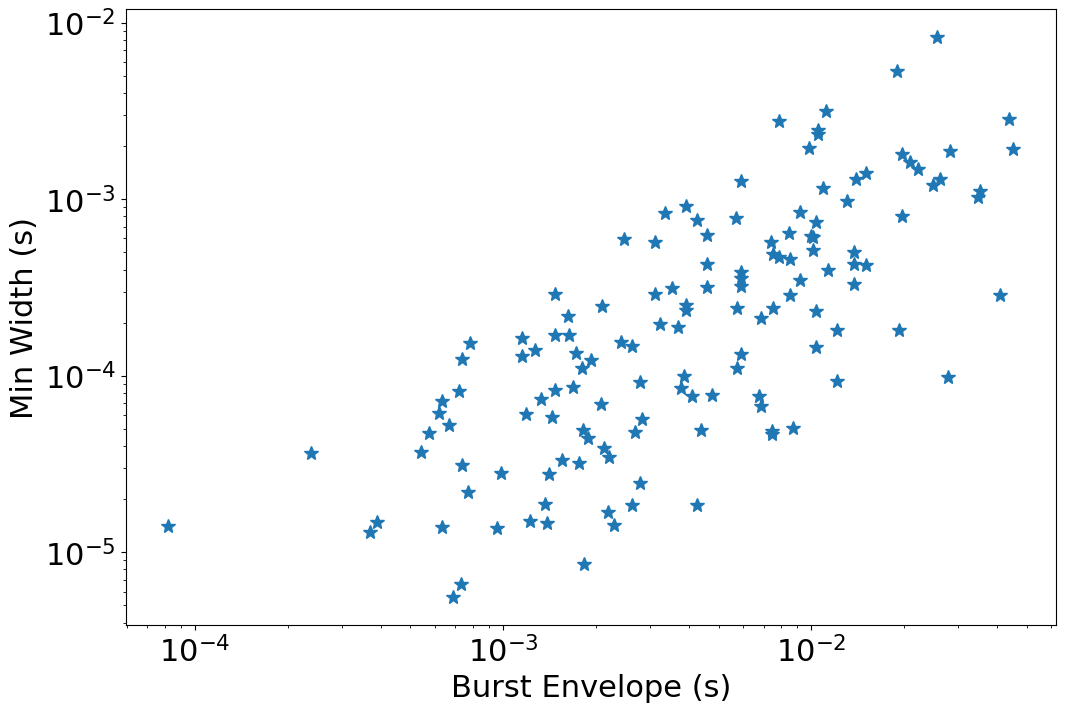

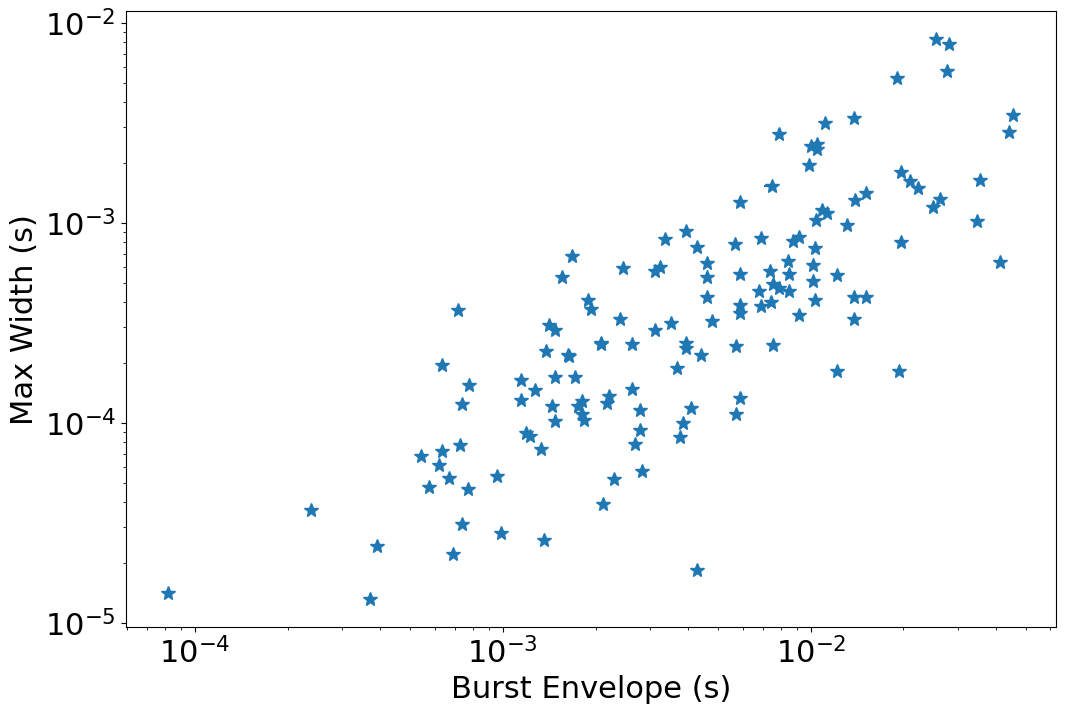

In [21]:
min_w = data_basecat['Min_width(s)'].to_numpy()
min_w_err = data_basecat['Min_width_err(s)'].to_numpy()

max_w = data_basecat['Max_width(s)'].to_numpy()
max_w_err = data_basecat['Max_width_err(s)'].to_numpy()

# for i in range(len(min_w)):
#     print(min_w[i]*1e3, max_w[i]*1e3)

plt.errorbar(boxcar_base, min_w, boxcar_base_err, min_w_err, linestyle=' ', markersize = 10, marker = '*')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Burst Envelope (s)")
plt.ylabel("Min Width (s)")
plt.show()


plt.errorbar(boxcar_base, max_w, boxcar_base_err, max_w_err, linestyle = ' ', markersize = 10, marker = '*')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Burst Envelope (s)")
plt.ylabel("Max Width (s)")
plt.show()

[4.768360137867595e-05, 4.8295026501822585e-05, 6.706078347096188e-05, 0.000614494089507, 7.359974807495678e-05, 0.00047146557031800003, 0.000219619149669, 0.00028542229849700003, 0.00023144307874800002, 0.00021263974645800002, 1.3809704797136102e-05, 0.000291782248573, 0.00034791481981200003, 0.00018161724694200002, 0.00045698580027400004, 3.9256474602250354e-05, 0.00025153794564800004, 0.001164677243977, 0.000315390958298, 0.00141091491232, 1.8894037200672392e-05, 0.000130176985587, 0.000622355501442, 4.942111593969095e-05, 0.000747773666296, 0.001616350713764, 8.491534549599684e-05, 7.203499799334047e-05, 0.00038739999474800003, 8.279212043799824e-05, 0.000573166374685, 0.00013369129378000002, 0.000396656822695, 2.8095040721896234e-05, 0.000154800129403, 0.002847520500201, 0.00049201162509, 0.00042530349899200004, 0.00018194500549, 5.295049478279749e-05, 5.0455810687946275e-05, 7.706108215056777e-05, 5.7272138056991034e-05, 0.00011130055128300001, 0.0008506290581750001, 0.0002430389

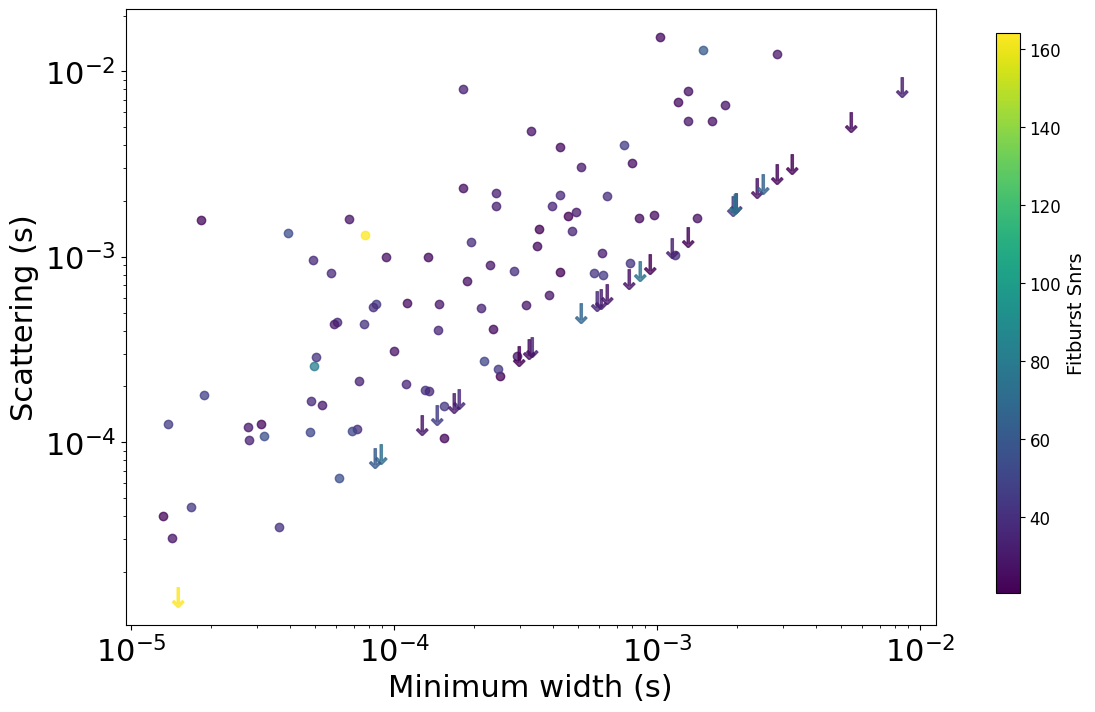

In [22]:
#### Scattering vs minimum width #########

scat_measured = data_only_scat_final['Scattering(s)'].to_numpy()
widths_measured = data_only_scat_final['Min_width(s)'].to_numpy()
print(widths_measured.tolist())
fit_snrs = data_only_scat_final['Fit_snr'].to_numpy()
time_res_measured = data_only_scat_final['Time_res(s)'].to_numpy()
ratio = data_only_scat_final['Ratio(w/s)'].to_numpy()


widths_measured_upper_limits = data_no_scat_final['Min_width(s)'].to_numpy()
scat_measured_upper_limits = widths_measured_upper_limits
time_res_upper_limits = data_no_scat_final['Time_res(s)'].to_numpy()
fit_snrs_upper_limits = data_no_scat_final['Fit_snr'].to_numpy()

# ds_factor = int(time_res_measured/2.56e-6)

# print(scat_measured.tolist())
# print(widths_measured.tolist())
# print(fit_snrs.tolist())

# bins=8
# hist, bins_w = np.histogram(widths_measured, bins=bins)
# logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
# x = plt.hist(widths_measured, bins=logbins, color='green', alpha=0.7, edgecolor='k')
# print(x)
# plt.xscale('log')
# plt.show()

# y = plt.hist(ratio, bins=bins, color='orange', alpha=0.7, edgecolor='k')
# print(y)
# plt.show()

# z = plt.hist(fit_snrs, bins=20, color='pink', alpha=0.7, edgecolor='k')
# print(z)
# plt.show()

# t = plt.hist(time_res_measured, bins=10, color='pink', alpha=0.7, edgecolor='k')
# print(t)
# plt.show()

fig = plt.figure()

norm = mpl.colors.Normalize(vmin=np.min(fit_snrs), vmax=np.max(fit_snrs), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
snr_color = np.array([(mapper.to_rgba(v)) for v in fit_snrs])


for x, y, color in zip(widths_measured, scat_measured, snr_color): 
    plt.scatter(x, y, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    
norm = mpl.colors.Normalize(vmin=np.min(fit_snrs_upper_limits), vmax=np.max(fit_snrs_upper_limits), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
snr_color = np.array([(mapper.to_rgba(v)) for v in fit_snrs_upper_limits])


for x, y, color in zip(widths_measured_upper_limits, scat_measured_upper_limits, snr_color): 
    plt.scatter(x, y, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', s=200)

# simulated_scatters = np.array([0.002, 0.001, 0.0008, 0.0005, 0.0001, 1e-05])
# simulated_scatter_width = np.full(6,0.001)

# plt.plot(simulated_scatter_width, simulated_scatters)

# simulated_widths = np.array([0.01, 0.0025, 0.0008, 0.0005, 0.0001, 0.00001])
# simulated_width_scatter = np.full(6,0.0008)

# plt.plot(simulated_widths, simulated_width_scatter, color='green')

plt.yscale('log')
plt.xscale('log')

plt.xlabel("Minimum width (s)")
plt.ylabel("Scattering (s)")


##### Adjusting the color bar #######
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)
#ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
# # print(ytick_lab)
#cbar_ax.set_yticklabels(ytick_lab)
cb.set_label(label=r'Fitburst Snrs', size=14)
cbar_ax.tick_params(labelsize=12)

plt.show()

In [23]:
min_width_no_scat = data_no_scat_final['Min_width(s)'].to_numpy()
print(min_width_no_scat.tolist())
print(len(min_width_no_scat))
fit_snrs_no_scat = data_no_scat_final['Fit_snr'].to_numpy()
print(fit_snrs_no_scat.tolist())
events_no_scat = data_no_scat_final['Event'].to_numpy()
print(events_no_scat.tolist())

[0.000576308665919, 1.4587967783511161e-05, 0.000628489529293, 0.000324841983142, 0.005308893804553, 8.68293922689184e-05, 0.002334986736937, 0.0005001079216750001, 0.000316497180416, 0.000594259059581, 0.0008338314537420001, 0.0019455833566370002, 0.001889416536366, 0.002464742068473, 0.0019207491201810002, 0.0012723498723700001, 0.002782271260077, 8.238140691082549e-05, 0.000170782835253, 0.000140885199844, 0.0031530177487020003, 0.000912635735845, 0.00016367575750000002, 0.001110273515093, 0.008283127676383001, 0.00029057236642000004, 0.0007595756300210001, 0.00012408040080100002]
28
[36.49425553789771, 164.13818524775277, 28.08452942679121, 35.763610471467125, 23.76585793741657, 71.21624616806025, 26.489272854392382, 66.59214142358421, 26.010192339024197, 32.739958690355486, 74.60910880648757, 34.58026314352688, 44.91362611345186, 64.25393954428813, 76.35660843690185, 21.679894384358256, 22.286505711234284, 60.462634214244204, 37.49429772282609, 46.43270534490871, 20.93014667646874

137 137
Number of bursts covering full bandwidth 114

 KstestResult(statistic=0.46715328467153283, pvalue=7.092554636034424e-14)
Anderson_ksampResult(statistic=55.70555498102759, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
137 137 137
KS-test KstestResult(statistic=0.25547445255474455, pvalue=0.0002448918747858891)
AD-test Anderson_ksampResult(statistic=12.080122146646671, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)


/tmp/ipykernel_5347/4044638554.py:27: UserWarning: p-value floored: true value smaller than 0.001
  ad_b = scipy.stats.anderson_ksamp([band_frac,band_frac_int])
/tmp/ipykernel_5347/4044638554.py:60: UserWarning: p-value floored: true value smaller than 0.001
  ad = scipy.stats.anderson_ksamp([bw_base_del,bw_int_del])


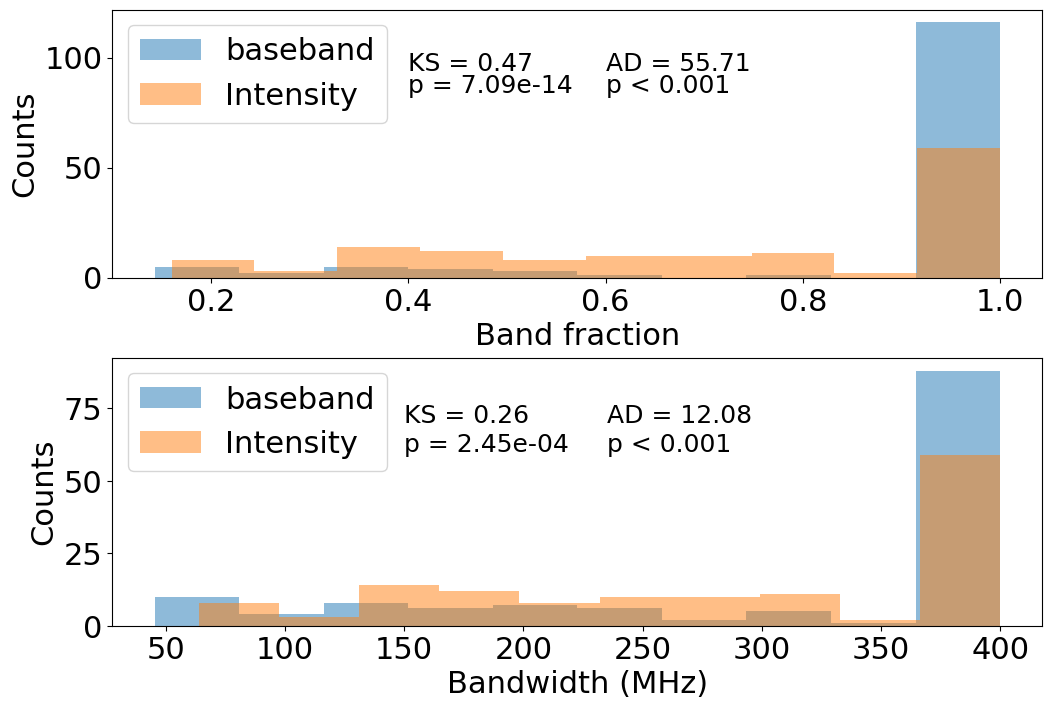

In [31]:
#### Bandwidth ####

### Do a AD or KS test to find difference in value ######

bw_base = data_final_basecat['Bandwidth'].to_numpy().astype(float)
print(len(bw_base), len(bws_int))

bw_top = data_final_basecat['Top_avail_freq'].to_numpy()
bw_bottom = FREQ_BOTTOM_MHZ

bw_band = bw_top - FREQ_BOTTOM_MHZ

band_frac = bw_base / bw_band

x = len(np.where(band_frac == 1.0)[0])
print("Number of bursts covering full bandwidth", x)

band_frac_int = bws_int / 400.


fig, axs = plt.subplots(nrows=2, ncols=1)
plt.subplots_adjust(hspace = 0.3)


ks_b = scipy.stats.ks_2samp(band_frac, band_frac_int)
print("\n",ks_b)
ad_b = scipy.stats.anderson_ksamp([band_frac,band_frac_int])
print(ad_b)

axs[0].hist(band_frac, alpha=0.5, label='baseband')
axs[0].hist(band_frac_int, alpha = 0.5, label='Intensity')
axs[0].text(0.4, 94, 'KS = {}'.format(round(ks_b[0],2)), fontsize=18)
axs[0].text(0.4, 84, 'p = {:.2e}'.format(ks_b[1]), fontsize=18)
axs[0].text(0.6, 94, 'AD = {}'.format(round(ad_b[0],2)), fontsize=18)
axs[0].text(0.6, 84, 'p < {}'.format(0.001), fontsize=18)
axs[0].set_xlabel("Band fraction")
axs[0].set_ylabel("Counts")
axs[0].legend()

#### Add intensity data here #####

idx = np.where(bw_base == 0)[0]

bw_base_del = np.delete(bw_base, idx)
bw_int_del = np.delete(bws_int, idx)
events_del = np.delete(events, idx)
print(len(events_del), len(bw_base_del), len(bw_int_del))





# for i in range(len(events_del)):
#     if (bw_base_del[i] - bw_int_del[i] < -20) : #### I checked the waterfall these events seem to be overestimated in intensity data ########
#         print("Event=", events_del[i], "Baseband_bw = ", bw_base_del[i], "Intensity_bw = ", bw_int_del[i])


ks = scipy.stats.ks_2samp(bw_base_del, bw_int_del)
print("KS-test",ks)
ad = scipy.stats.anderson_ksamp([bw_base_del,bw_int_del])
print("AD-test",ad)

axs[1].hist(bw_base_del, alpha=0.5, label='baseband')
axs[1].hist(bw_int_del, alpha = 0.5, label='Intensity')
axs[1].text(150, 70, 'KS = {}'.format(round(ks[0],2)), fontsize=18)
axs[1].text(150, 60, 'p = {:.2e}'.format(ks[1]), fontsize=18)
axs[1].text(235, 70, 'AD = {}'.format(round(ad[0],2)), fontsize=18)
axs[1].text(235, 60, 'p < {}'.format(0.001), fontsize=18)
axs[1].set_xlabel("Bandwidth (MHz)")
axs[1].set_ylabel("Counts")
axs[1].legend()

oname = 'Paper_plots/Bandwidth_baseband_vs_intensity_band_frac.pdf'
plt.savefig(oname, dpi=300, bbox_inches='tight')

plt.show()




#### The bandwidth distribution is different #####

41710598 1.835772529563633e-06 3.372729006644472e-06


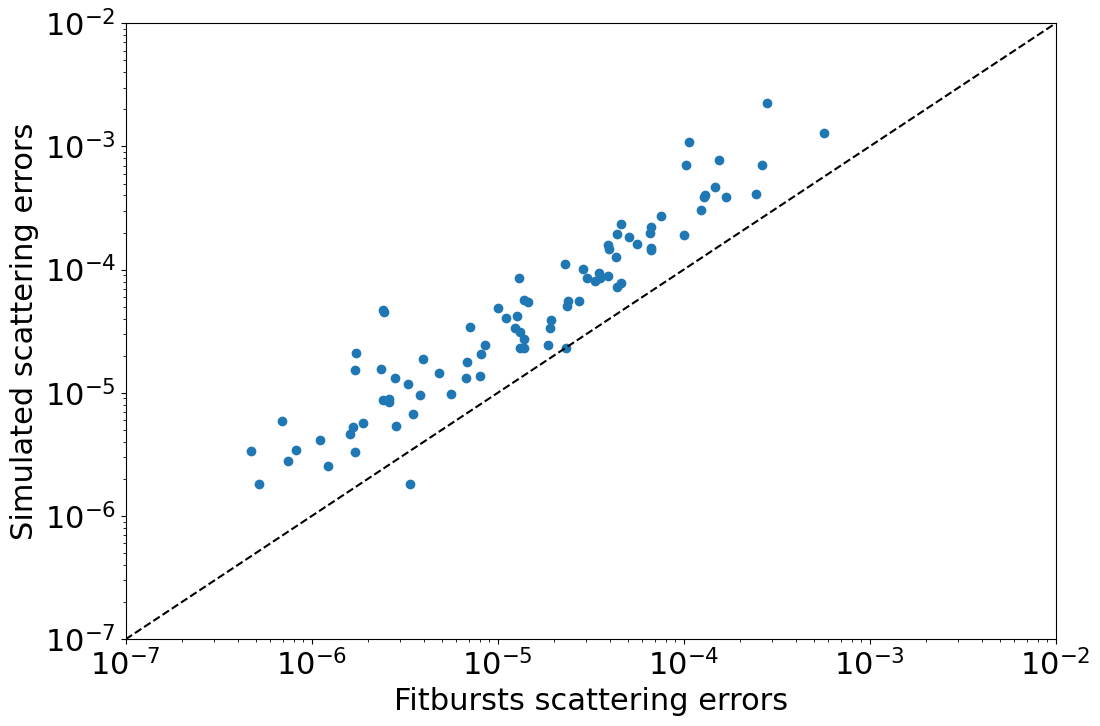

In [19]:
sc_errs = data_only_scat_final['Scattering_err(s)'].to_numpy()
sc_errs_sim = data_only_scat_final['Scattering_err_sim(s)'].to_numpy()
events = data_only_scat_final['Event'].to_numpy()

for i in range(len(events)):
    if sc_errs_sim[i] < sc_errs[i]:
        print(events[i], sc_errs_sim[i], sc_errs[i])

plt.scatter(sc_errs, sc_errs_sim)
#plt.ylim(np.min(sc_errs), np.max(sc_errs_sim)+0.001)
x = [1e-7,1e-2]
y = [1e-7,1e-2]
plt.plot(x, y, linestyle='--', c='k')
plt.xlim(1e-7,1e-2)
plt.ylim(1e-7,1e-2)
plt.xlabel("Fitbursts scattering errors")
plt.ylabel("Simulated scattering errors")
plt.yscale('log')
plt.xscale('log')
plt.show()

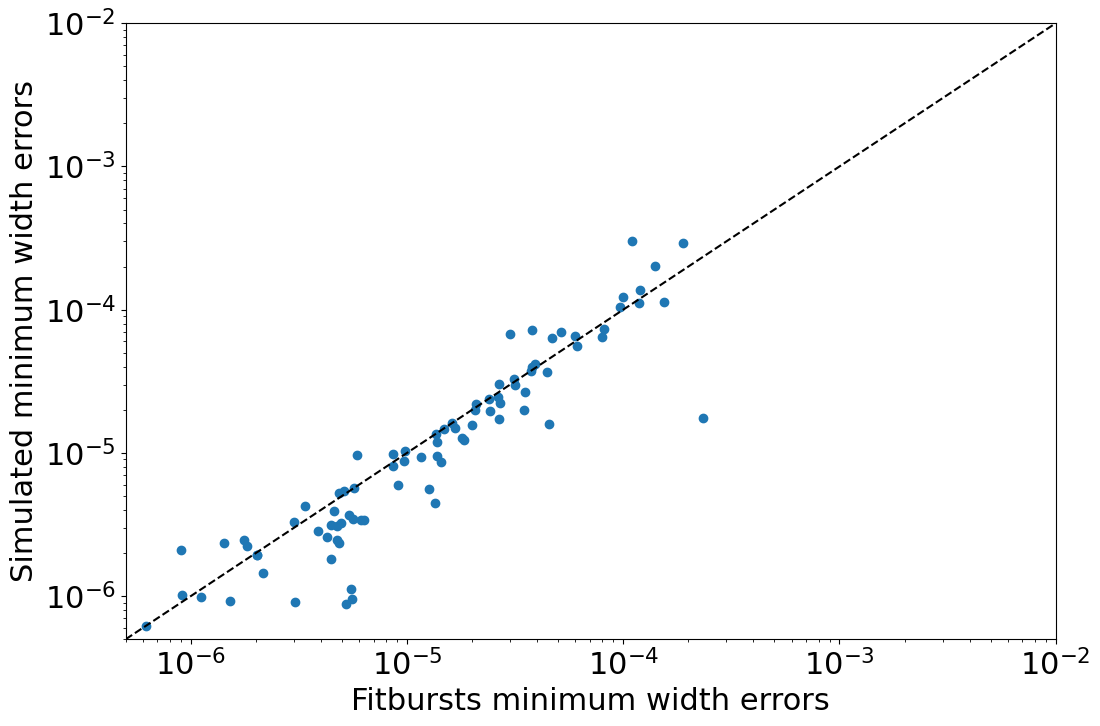

In [20]:
min_width_errs = data_only_scat_final['Min_width_err(s)'].to_numpy()
min_width_errs_sim = data_only_scat_final['Min_width_err_sim(s)'].to_numpy()
events = data_only_scat_final['Event'].to_numpy()

# for i in range(len(events)):
#     if min_width_errs_sim[i] < min_width_errs[i]:
#         print(events[i], min_width_errs_sim[i], min_width_errs[i])

plt.scatter(min_width_errs, min_width_errs_sim)
#plt.ylim(np.min(sc_errs), np.max(sc_errs_sim)+0.001)
x = [5e-7,1e-2]
y = [5e-7,1e-2]
plt.plot(x, y, linestyle='--', c='k')
plt.xlim(5e-7,1e-2)
plt.ylim(5e-7,1e-2)
plt.xlabel("Fitbursts minimum width errors")
plt.ylabel("Simulated minimum width errors")
plt.yscale('log')
plt.xscale('log')
plt.show()

(176,) (179,)


ValueError: x and y must be the same size

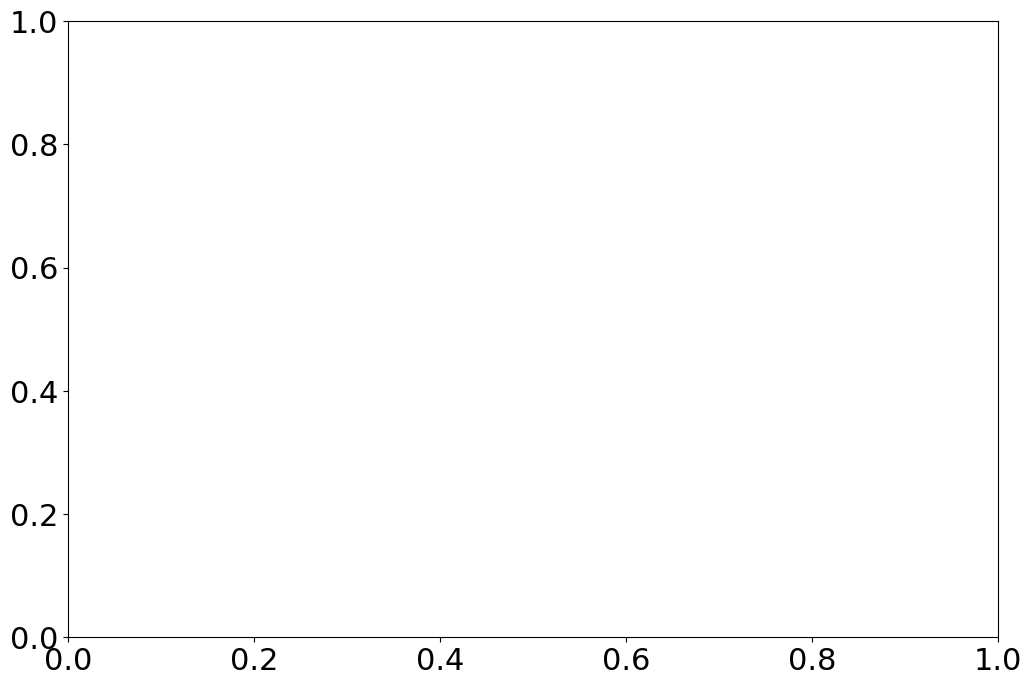

In [21]:
widths_base_err = data_final_basecat_no_profile['Widths_err(s)'].to_numpy()
widths_base_err = np.concatenate(widths_base_err)
widths_base_err = np.array([0 if element is None else element for element in widths_base_err])



widths_base_err_sim = data_final_basecat_no_profile['Widths_err_sim(s)'].to_numpy()
widths_base_err_sim = np.concatenate(widths_base_err_sim)
widths_base_err_sim = np.array([0 if element is None else element for element in widths_base_err_sim])

print(widths_base_err.shape, widths_base_err_sim.shape)

#events = data_only_scat_final['Event'].to_numpy()

# for i in range(len(events)):
#     if min_width_errs_sim[i] < min_width_errs[i]:
#         print(events[i], min_width_errs_sim[i], min_width_errs[i])

plt.scatter(widths_base_err, widths_base_err_sim)
#plt.ylim(np.min(sc_errs), np.max(sc_errs_sim)+0.001)
x = [5e-7,1e-2]
y = [5e-7,1e-2]
plt.plot(x, y, linestyle='--', c='k')
plt.xlim(5e-7,1e-2)
plt.ylim(5e-7,1e-2)
plt.xlabel("Fitbursts width errors")
plt.ylabel("Simulated width errors")
plt.yscale('log')
plt.xscale('log')
plt.show()

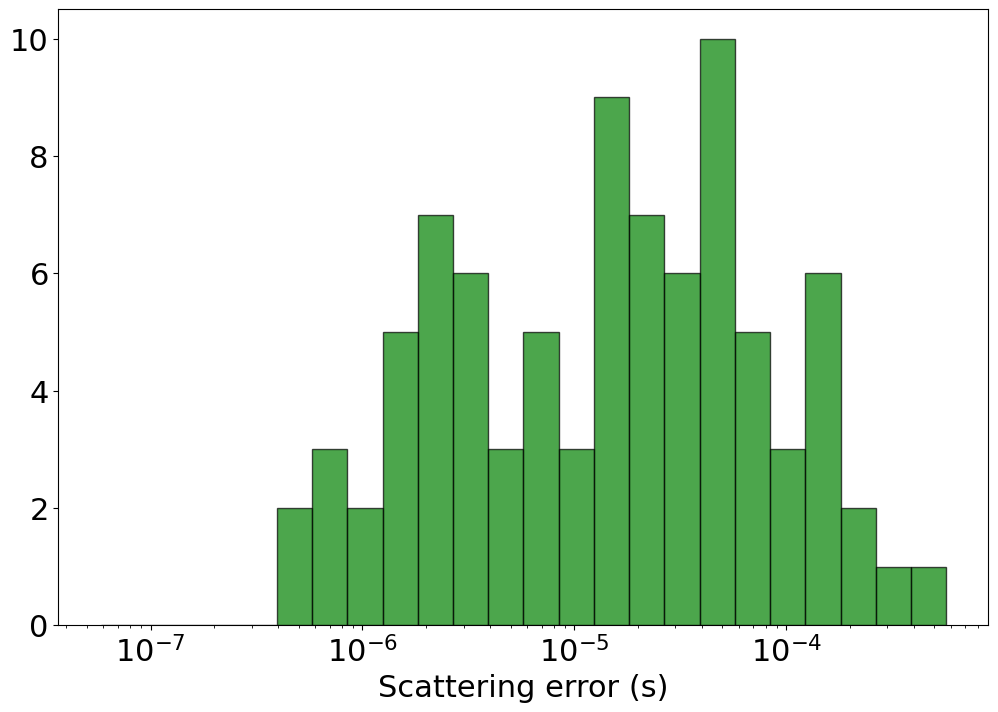

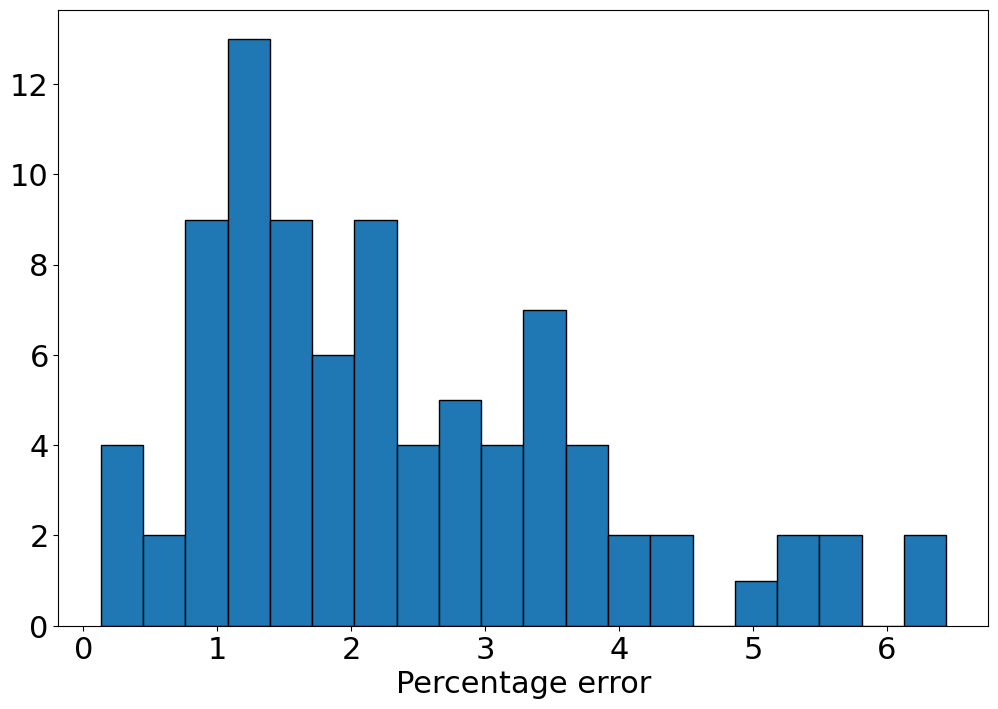

In [22]:
#### Histogram of scattering error distribution ###

#### also calculate percentage error ####

sc_errs = data_only_scat_final['Scattering_err(s)'].to_numpy()

sc_errs[np.isnan(sc_errs)] = 10 #### Changing nan values to 10

hist, bins_w = np.histogram(sc_errs, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(sc_errs, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Scattering error (s)')
plt.show()


data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json') #### Loading basecat information ####
data_only_scat = data_basecat[(data_basecat['Fit_type'] == 'Scint') | (data_basecat['Fit_type'] == 'Scat')]

scats_1 = data_only_scat['Scattering(s)'].to_numpy()
sc_errs_1 = data_only_scat['Scattering_err(s)'].to_numpy()
per = (sc_errs_1/scats_1)*100
plt.hist(per, bins=20, edgecolor='k')
plt.xlabel('Percentage error')
plt.show()


Sub bursts with no error estimates, this includes failed events 3
The percentage is 1.4150943396226416


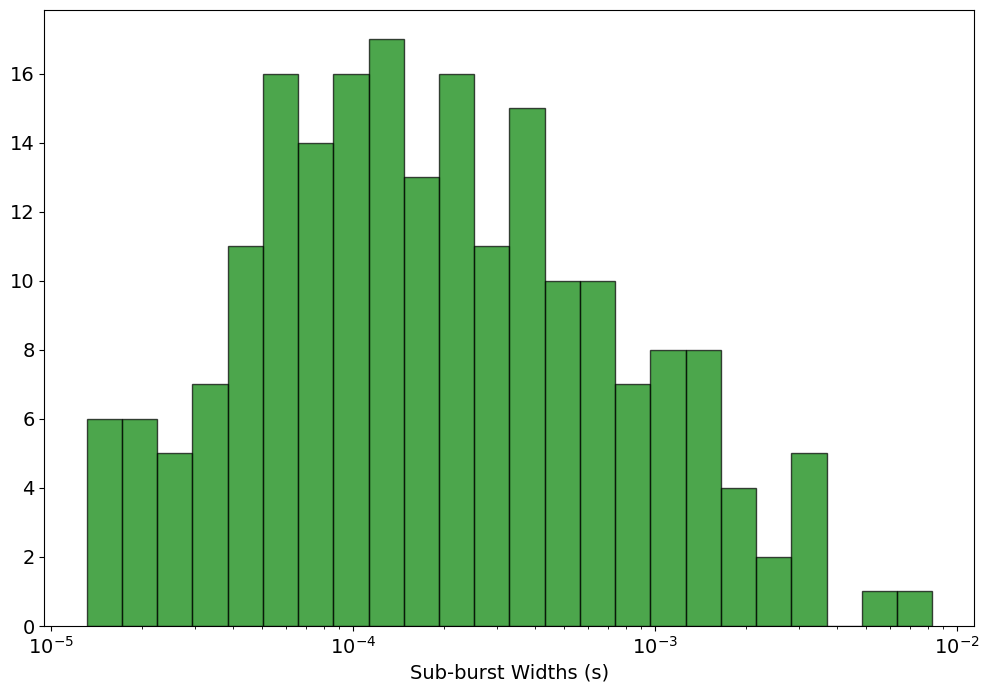

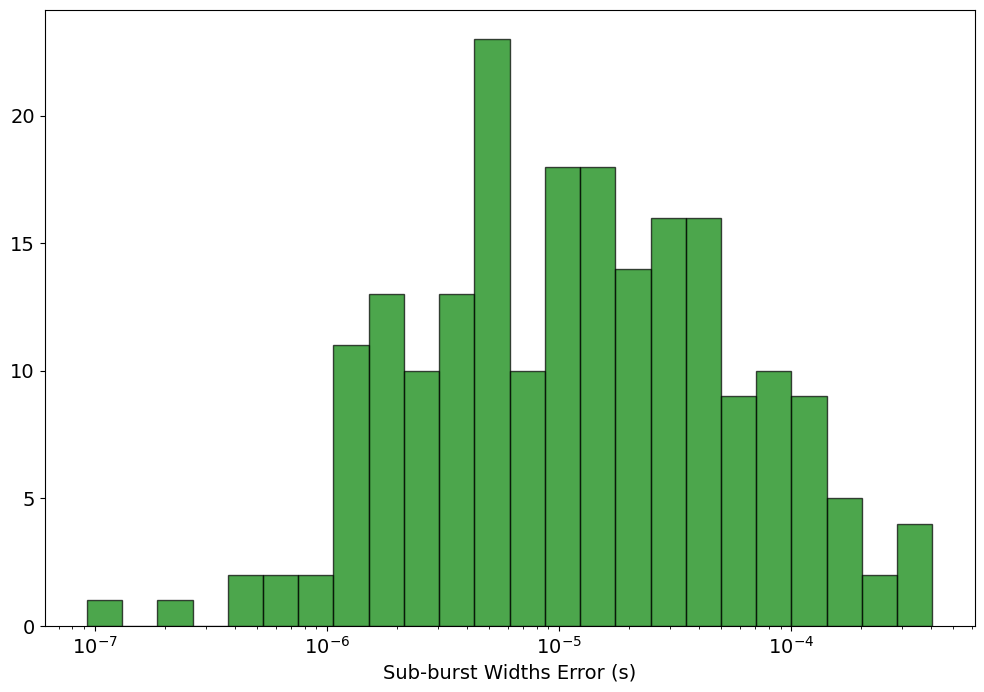

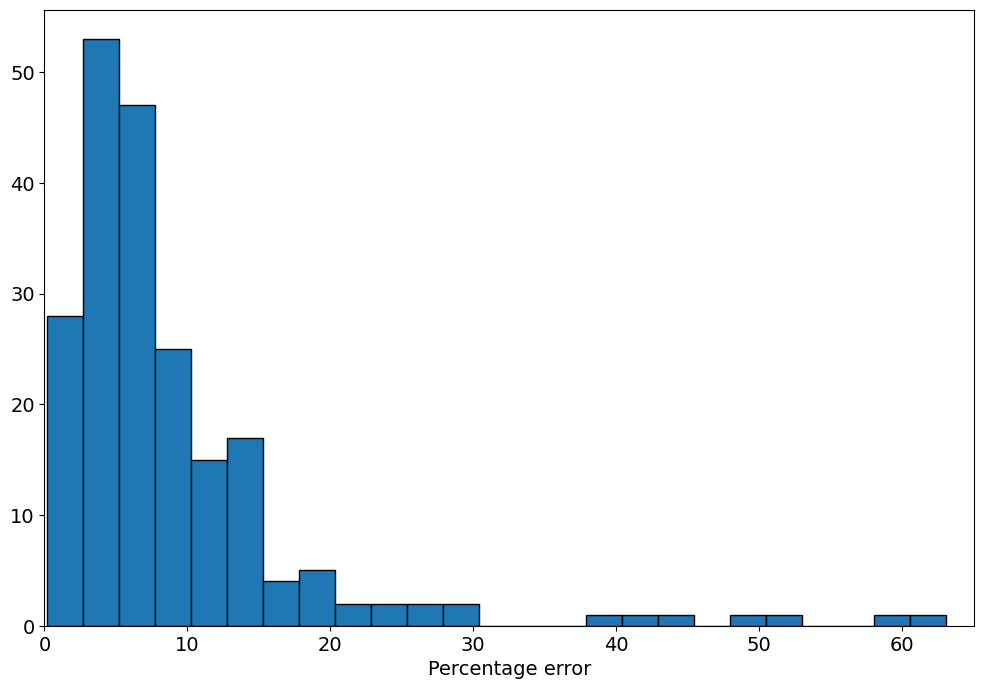

In [291]:
#### Histogram of width error distribution ###

#### also calculate percentage error ####

##### Combine all the sub-bursts width informations and also their error informations ######

widths_base = data_final_basecat['Widths(s)'].to_numpy()
widths_base = np.concatenate(widths_base)

widths_base_err = data_final_basecat['Widths_err(s)'].to_numpy()
widths_base_err = np.concatenate(widths_base_err)
widths_base_err = np.array([0 if element is None else element for element in widths_base_err])

idx = np.where(widths_base_err == 0)[0]
print("Sub bursts with no error estimates, this includes failed events", len(idx))
print("The percentage is", (len(idx)/len(widths_base))*100)

widths_base_del = np.delete(widths_base, idx)
widths_base_err_del = np.delete(widths_base_err, idx)

hist, bins_w = np.histogram(widths_base_del, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(widths_base_del, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Sub-burst Widths (s)')
plt.show()

hist, bins_w = np.histogram(widths_base_err_del, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(widths_base_err_del, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Sub-burst Widths Error (s)')
plt.show()

per = (widths_base_err_del/widths_base_del)*100

# for i in range(len(per)):
#     if per[i] > 100:
#         print(widths_base_err_del[i], widths_base_del[i])
#         per[i] = 0

plt.hist(per, bins=25, edgecolor='k')
plt.xlabel('Percentage error')
plt.xlim(0,np.max(per)+2)
plt.show()


Number of events with more components in baseband is 21 thats total percentage 16.27906976744186 %


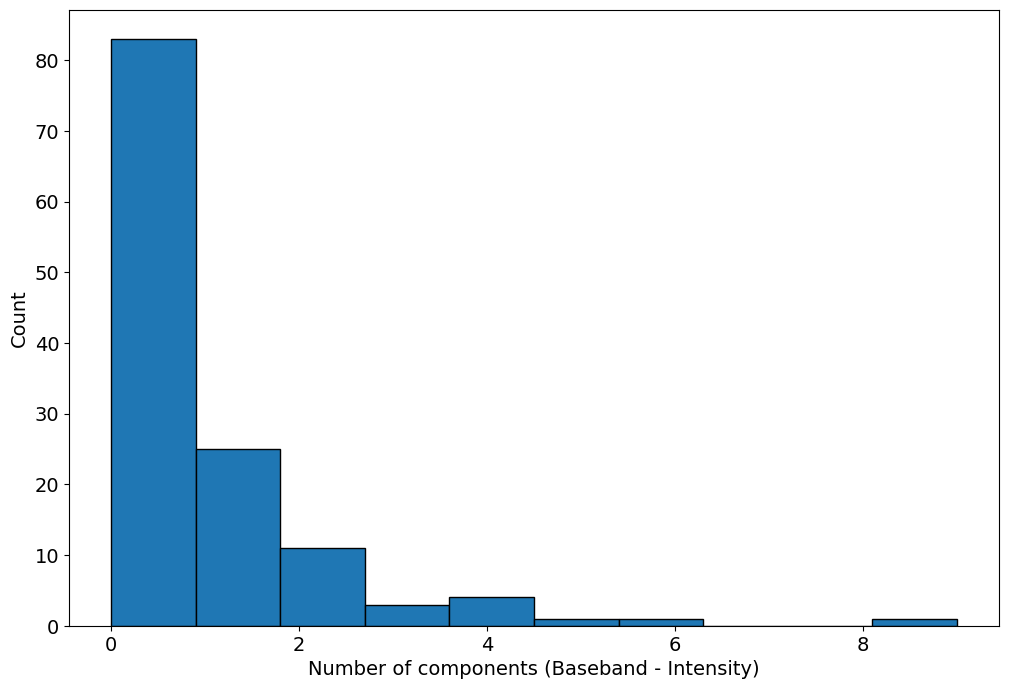

-9.039947063165288 -2.081805644361072
[9.12122013e-10 3.31325983e-04 6.62651053e-04 9.93976124e-04
 1.32530119e-03 1.65662626e-03 1.98795134e-03 2.31927641e-03
 2.65060148e-03 2.98192655e-03 3.31325162e-03 3.64457669e-03
 3.97590176e-03 4.30722683e-03 4.63855190e-03 4.96987697e-03
 5.30120204e-03 5.63252711e-03 5.96385218e-03 6.29517725e-03
 6.62650232e-03 6.95782739e-03 7.28915246e-03 7.62047754e-03
 7.95180261e-03 8.28312768e-03]


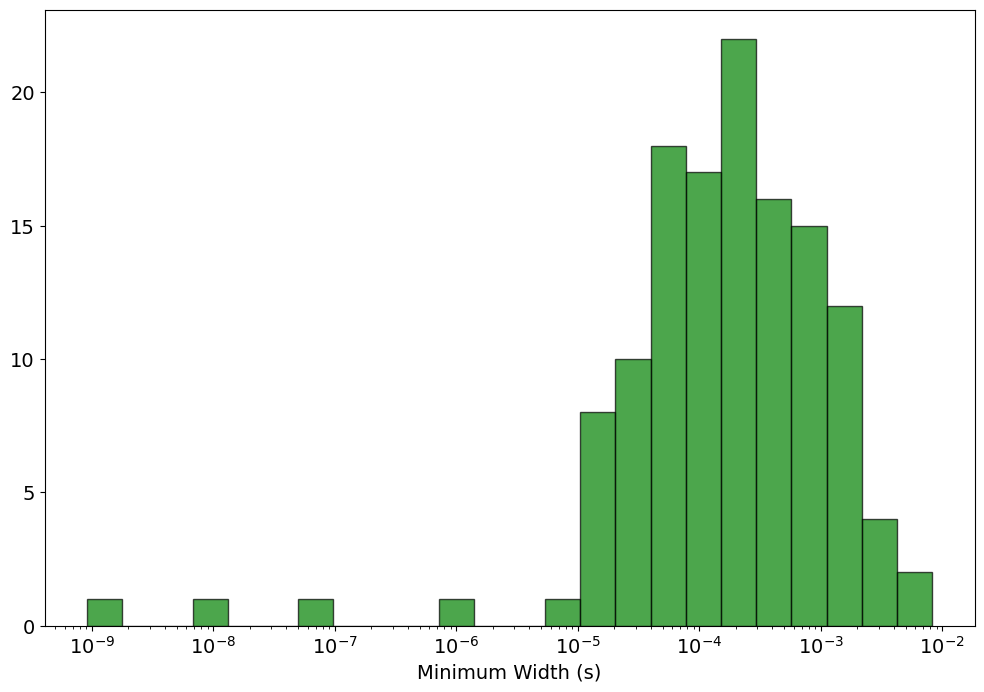

22457855 1.1440632140801051e-08
25677682 0.000628489529293
25884250 0.000130176985587
28783556 8.491534549599684e-05
34532625 6.0401577154230366e-05
36234050 0.000316497180416
38536189 7.690178262021085e-05
39095517 5.8666504845493545e-05
40750656 0.0019207491201810002
41006263 0.000331657298988
41643446 7.736969596147915e-05
42545361 0.008283127676383001
43054366 0.001492072233829


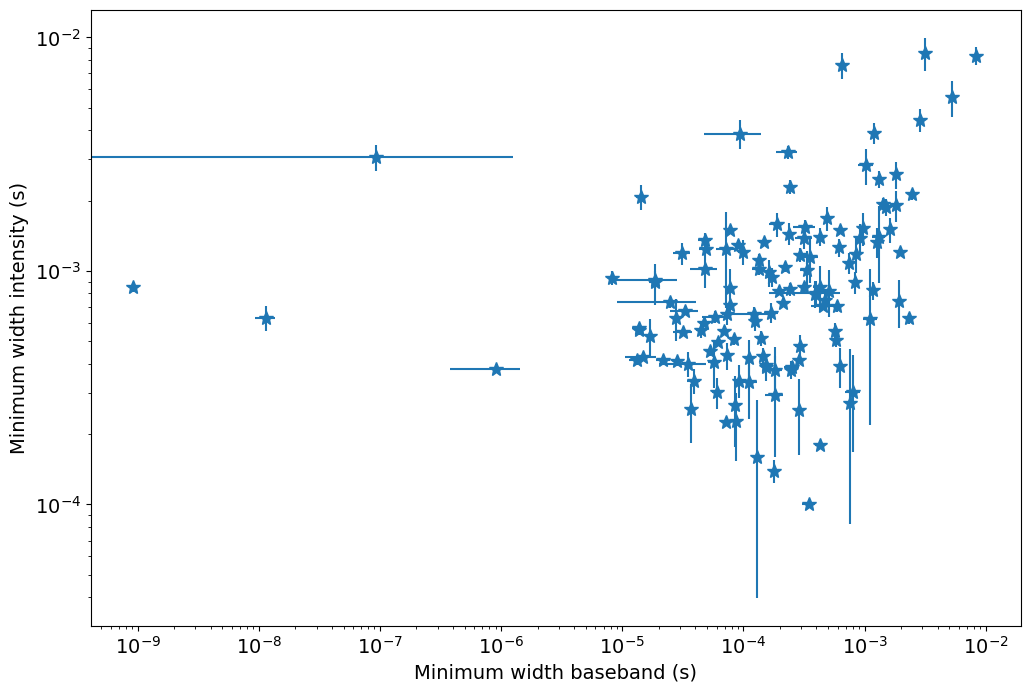

Sub bursts with no error estimates, this includes failed events 16
The percentage is 6.6115702479338845


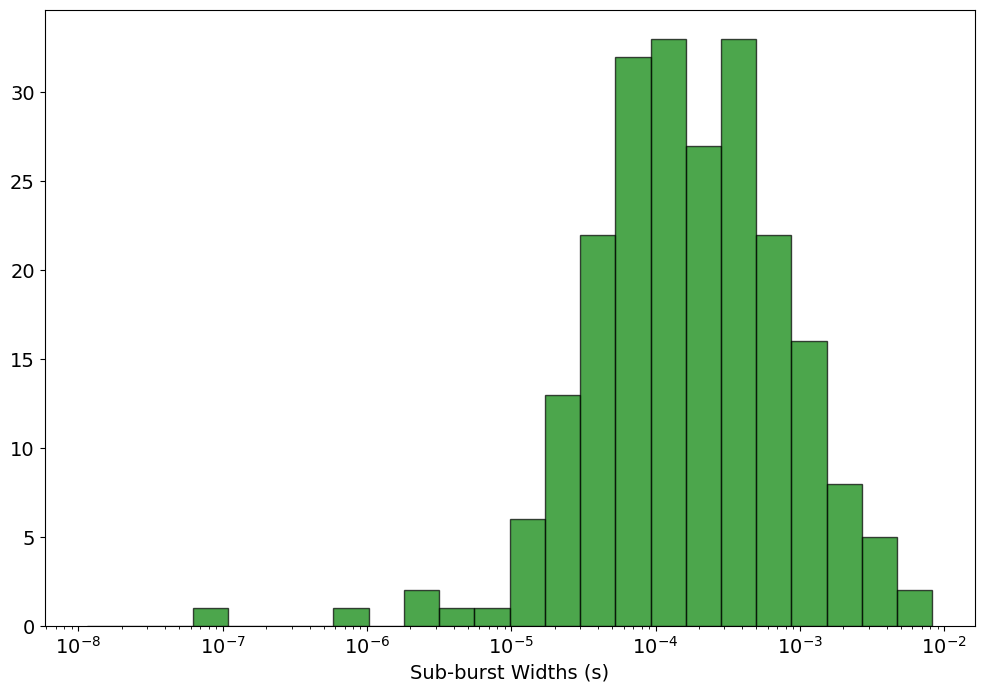

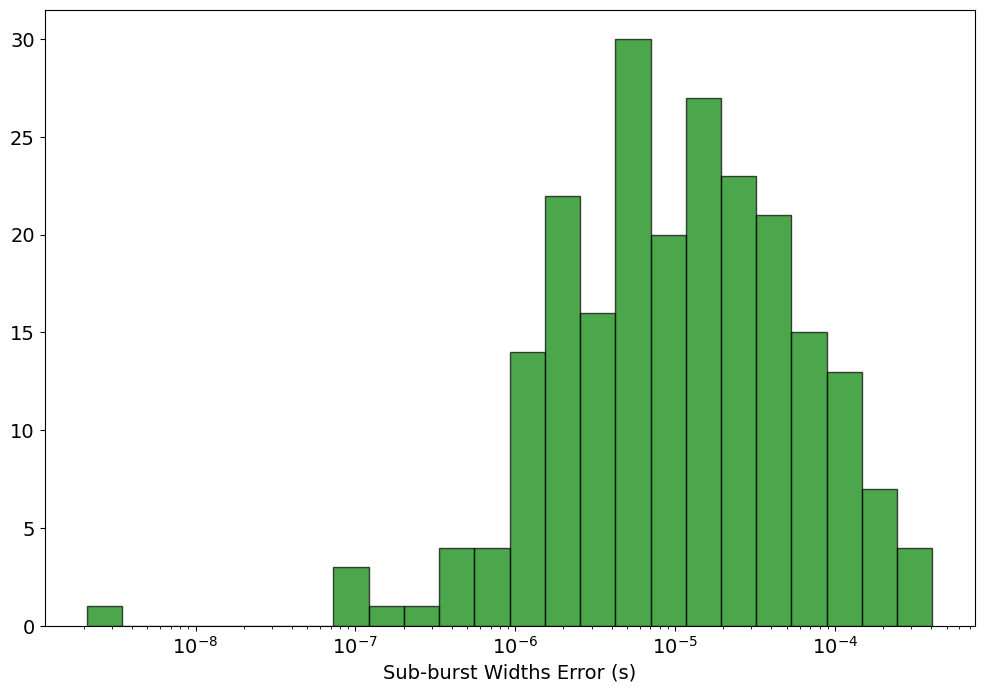

1.167386970100337e-06 9.32526056840322e-08


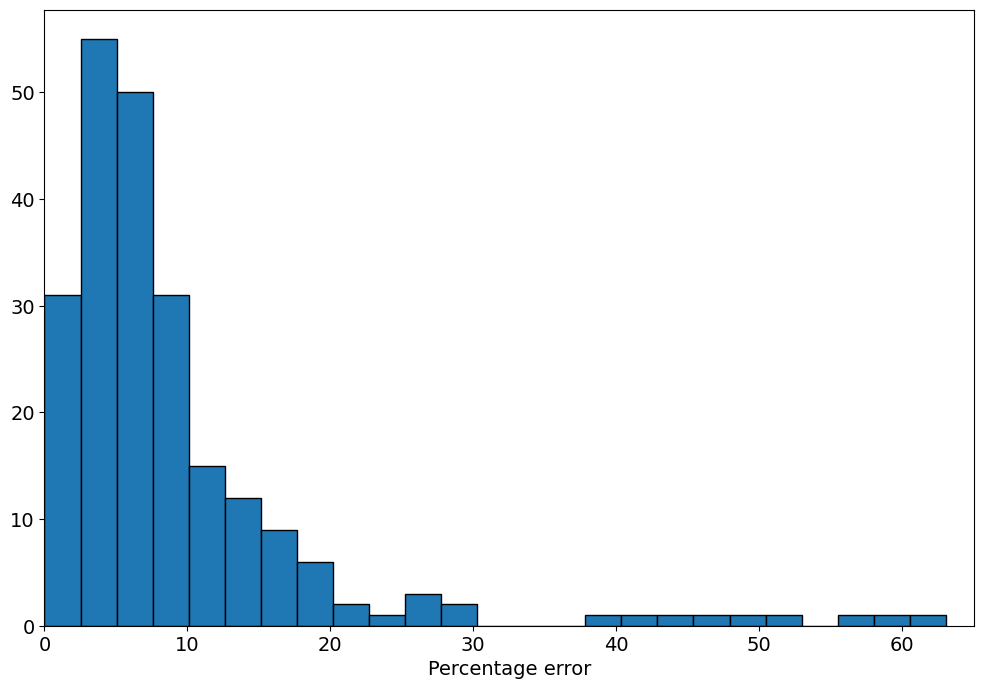

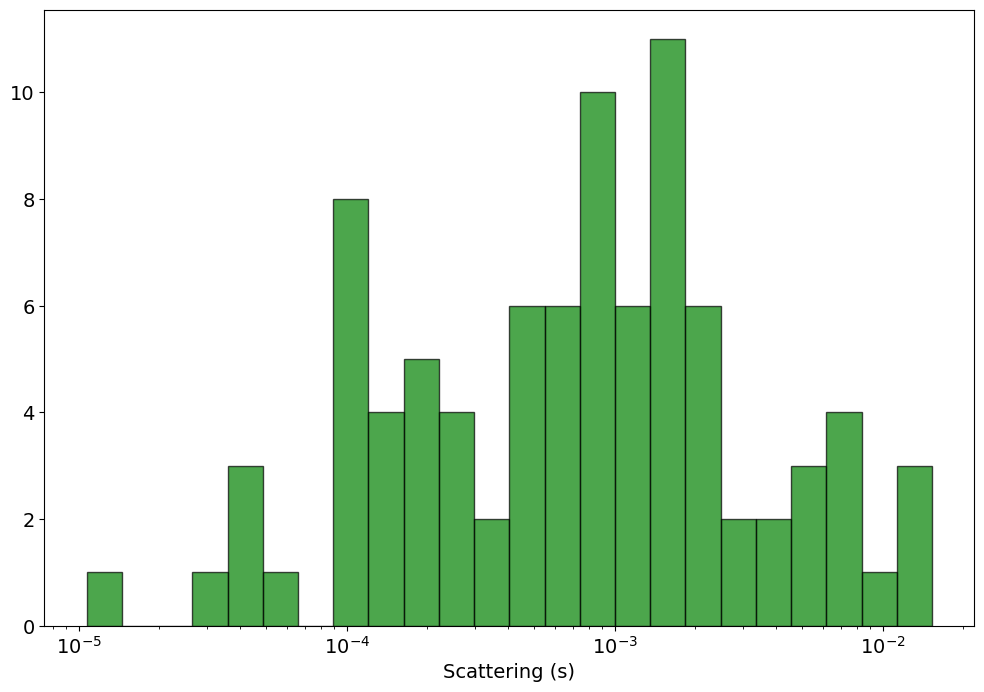

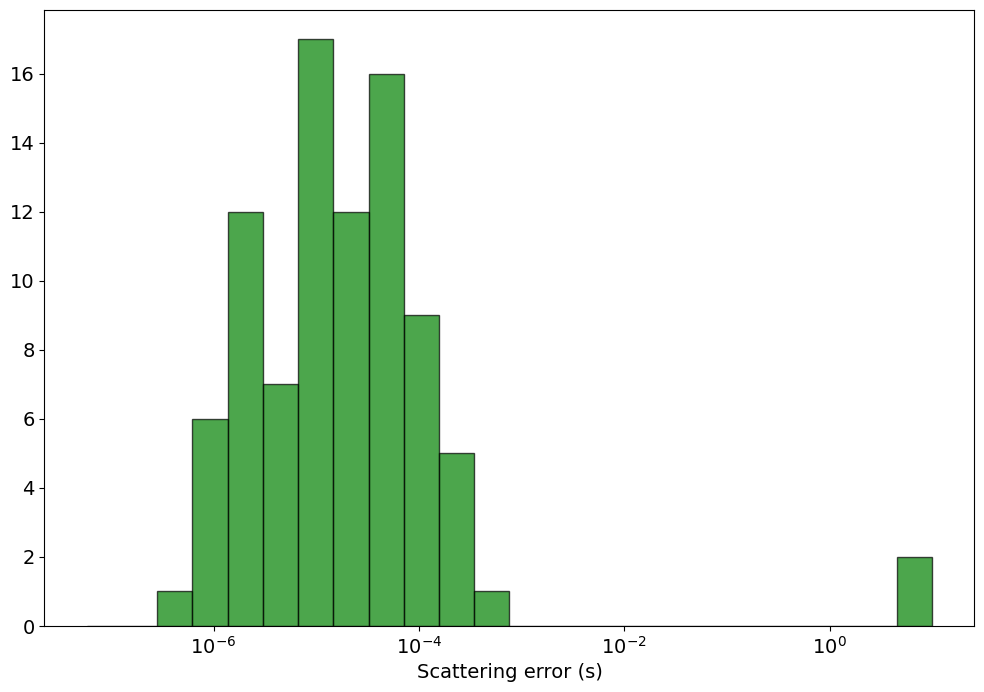

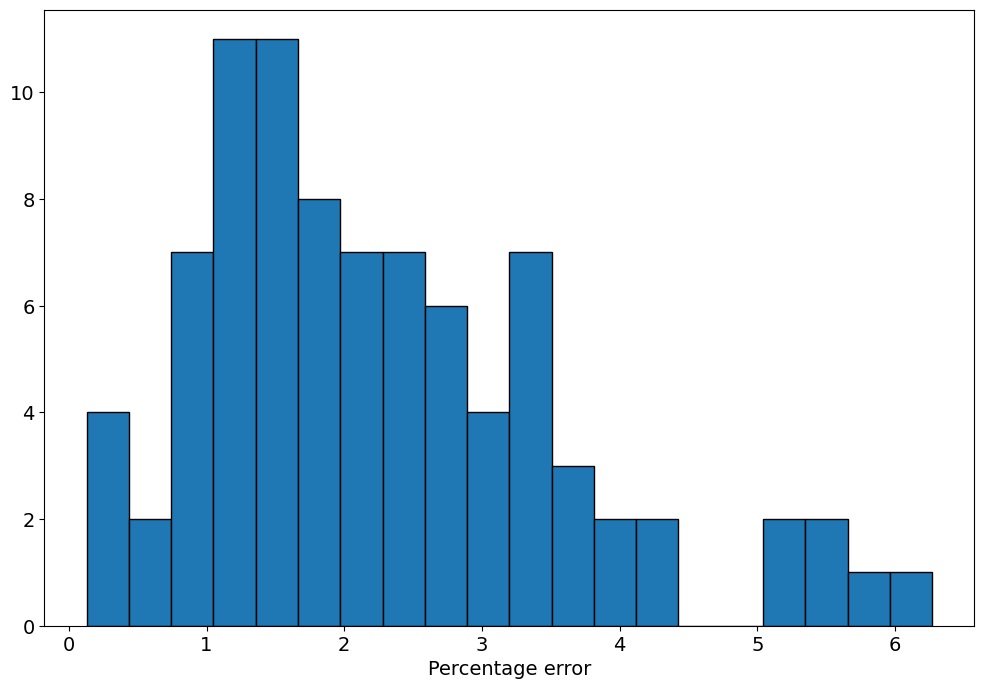

In [444]:
#### Plotting all distribution without removing any ######

data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json') #### Loading basecat information ####

data_only_scat = data_basecat[(data_basecat['Fit_type'] == 'Scint') | (data_basecat['Fit_type'] == 'Scat')]


events = data_basecat['Event'].to_numpy().astype(str)

df_new_cat = df_cat[df_cat['event_number'].isin(events)] 

df_new_cat = df_new_cat.sort_values(by = 'event_number')



events_int = df_new_cat['event_number'].to_numpy().astype(int)
dms_int = df_new_cat['fitburst_dm'].to_numpy().astype(float)
dms_int_err = df_new_cat['fitburst_dm_error'].to_numpy().astype(float)
scats_int = df_new_cat['scattering_time_ms'].to_numpy().astype(float)
scats_int_err = df_new_cat['scattering_time_ms_error'].to_numpy().astype(float)
widths_min_int = df_new_cat['pulse_width_min'].to_numpy().astype(float)
widths_min_int_err = df_new_cat['pulse_width_min_err'].to_numpy().astype(float)
bws_int = df_new_cat['bandwidth'].to_numpy().astype(float)
ncomps_int = df_new_cat['num_sub_bursts'].to_numpy().astype(int)


#### Num of comps ###

ncomps_base = data_basecat['Num_comps'].to_numpy().astype(int)

#### Removing failed events ###

idx = np.where(ncomps_base == 0)[0]


ncomps_base_del = np.delete(ncomps_base, idx)
ncomps_int_del = np.delete(ncomps_int, idx)

comp_diff = ncomps_base_del - ncomps_int_del

n = len(np.where(comp_diff > 1)[0])
print("Number of events with more components in baseband is", n, "thats total percentage", n*100/len(comp_diff), "%")

plt.hist(comp_diff, linewidth=1, edgecolor='k')
plt.xlabel("Number of components (Baseband - Intensity)")
plt.ylabel("Count")
plt.show()

###### Minimum width #############-----------------------------------

bins = 25

min_width_base = data_basecat['Min_width(s)'].to_numpy().astype(float)  
min_width_base_err = data_basecat['Min_width_err(s)'].to_numpy().astype(float)

min_width_base_err[np.isnan(min_width_base)] = 0

#### Removing failed events ####
idx = np.where(min_width_base == 0)[0]

min_width_base_del = np.delete(min_width_base, idx)
widths_min_int_del = np.delete(widths_min_int, idx)
min_width_base_err_del = np.delete(min_width_base_err, idx)
widths_min_int_err_del = np.delete(widths_min_int_err, idx)
events_del = np.delete(events, idx)

print(np.log10(min(min_width_base_del)), np.log10(max(min_width_base_del)))

hist, bins_w = np.histogram(min_width_base_del, bins=bins)
print(bins_w)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(min_width_base, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Minimum Width (s)')
plt.show()

wm = np.where(min_width_base < 1e-5)[0]

for w in wm:
    print(events_del[w], min_width_base_del[w])

plt.errorbar(min_width_base, widths_min_int, xerr = min_width_base_err ,yerr = widths_min_int_err, linestyle = ' ', markersize=10, marker='*')

plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.000008,0.02)
# plt.ylim(0.000008,0.02)
plt.xlabel("Minimum width baseband (s)")
plt.ylabel("Minimum width intensity (s)")
plt.show()


###### All widths ###################-----------------------------------------


widths_base = data_basecat['Widths(s)'].to_numpy()
widths_base = np.concatenate(widths_base)

widths_base_err = data_basecat['Widths_err(s)'].to_numpy()
widths_base_err = np.concatenate(widths_base_err)
widths_base_err = np.array([0 if element is None else element for element in widths_base_err])

idx = np.where(widths_base_err == 0)[0]
print("Sub bursts with no error estimates, this includes failed events", len(idx))
print("The percentage is", (len(idx)/len(widths_base))*100)

widths_base_del = np.delete(widths_base, idx)
widths_base_err_del = np.delete(widths_base_err, idx)

hist, bins_w = np.histogram(widths_base_del, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(widths_base_del, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Sub-burst Widths (s)')
plt.show()

hist, bins_w = np.histogram(widths_base_err_del, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(widths_base_err_del, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Sub-burst Widths Error (s)')
plt.show()

per = (widths_base_err_del/widths_base_del)*100

for i in range(len(per)):
    if per[i] > 100:
        print(widths_base_err_del[i], widths_base_del[i])
        per[i] = 0

plt.hist(per, bins=25, edgecolor='k')
plt.xlabel('Percentage error')
plt.xlim(0,np.max(per)+2)
plt.show()


######## Scattering ##########-----------------------------------


scats = data_only_scat['Scattering(s)'].to_numpy()

hist, bins_w = np.histogram(scats, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(scats, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Scattering (s)')
plt.show()



sc_errs = data_only_scat['Scattering_err(s)'].to_numpy()

sc_errs[np.isnan(sc_errs)] = 10 #### Changing nan values to 10

hist, bins_w = np.histogram(sc_errs, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]),np.log10(bins_w[-1]),bins)
plt.hist(sc_errs, bins=logbins, color='green', alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.xlabel('Scattering error (s)')
plt.show()


data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json') #### Loading basecat information ####
data_only_scat = data_basecat[(data_basecat['Fit_type'] == 'Scint') | (data_basecat['Fit_type'] == 'Scat')]

scats_1 = data_only_scat['Scattering(s)'].to_numpy()
sc_errs_1 = data_only_scat['Scattering_err(s)'].to_numpy()
per = (sc_errs_1/scats_1)*100
plt.hist(per, bins=20, edgecolor='k')
plt.xlabel('Percentage error')
plt.show()


In [467]:
v1 = 400
v2 = 600

sc2 = 0.0004

sc1 = (1.5**4) * sc2

print(sc1)

0.002025
